# Store Sales - Time Series Forecasting
#### Author: James Coffey
#### Date: 2025-08-29
#### Challenge URL: [Store Sales - Time Series Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting)

# Imports & settings

In [ ]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from xgboost import XGBRegressor

from forecasting_store_sales import (
    _ensure_daily,
    build_local_table,
    build_regional_table,
    create_onpromo_feat,
    event_study_onpromotion_starts,
    fill_one_store,
    fit_ridge_with_optuna,
    hybrid_predict_one_day,
    lags_row_for_date,
    make_dp,
    make_lags,
    make_oil_weekly_features,
    make_wide_target,
    make_wide_transactions,
    plot_ccf_oil_global_long,
    plot_ccf_onpromotion_pair_prewhiten,
    plot_ccf_transactions_store,
    plot_lags,
    plot_periodogram,
    seasonal_plot,
    summarize_onpromo_ccf_by_pair_prewhiten,
    summarize_transactions_ccf_allstores,
    zscore_cols,
)

warnings.filterwarnings("ignore")

SEED = 42
np.random.seed(SEED)

In [3]:
BASE_DIR = "/kaggle/input/store-sales-time-series-forecasting"

store_sales = pd.read_csv(
    f"{BASE_DIR}/train.csv",
    usecols=["store_nbr", "family", "date", "sales", "onpromotion"],
    dtype={
        "store_nbr": "category",
        "family": "category",
        "sales": "float32",
        "onpromotion": "uint32",
    },
    parse_dates=["date"],
    infer_datetime_format=True,
)
store_sales["date"] = store_sales.date.dt.to_period("D")

In [4]:
store_sales = store_sales.set_index(["store_nbr", "family", "date"]).sort_index()

Text(0, 0.5, 'Sales (rolling mean)')

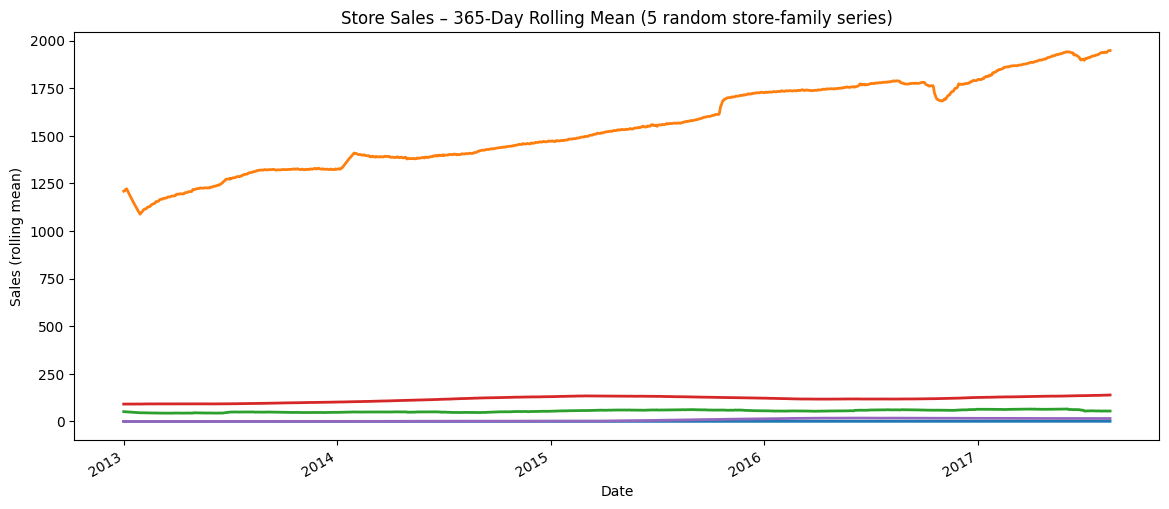

In [5]:
# 1) sample 5 random (store, family) pairs
pairs = store_sales.index.droplevel("date").unique()  # MultiIndex of (store, family)
rng = np.random.default_rng(42)  # change/remove seed for new draw
sel_pairs = pairs.take(rng.choice(len(pairs), size=5, replace=False))

# 2) filter rows for those pairs (all dates)
mask = store_sales.index.droplevel("date").isin(sel_pairs)
subset = store_sales.loc[mask, "sales"]  # Series with 3-level index

# 3) pivot wide: index=date, cols=(store, family)
to_plot = subset.unstack(["store_nbr", "family"]).sort_index()
to_plot.index = to_plot.index.to_timestamp()  # optional; makes plotting nicer

# 4) 365-day centered rolling mean
ma365 = to_plot.rolling(
    window=365,  # 365-day window
    center=True,  # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()  # compute the mean (could also do median, std, min, max, ...)

# 5) pretty column names and plot (no legend)
ma365.columns = [f"{s}-{f}" for (s, f) in ma365.columns]
ax = ma365.plot(figsize=(14, 6), linewidth=2, legend=False)
ax.set_title("Store Sales – 365-Day Rolling Mean (5 random store-family series)")
ax.set_xlabel("Date")
ax.set_ylabel("Sales (rolling mean)")

In [ ]:
# Wide target & DP features
y = make_wide_target(store_sales)  # (unchanged intent)
X = make_dp(y.index, order=2, weekly=False)  # trend-only first pass

# Split
idx_train = y.index < "2017-01-01"
idx_valid = ~idx_train

# ---- Trend-only Ridge (alpha in [1e3, 1e4]) ----
ridge_trend, study_trend = fit_ridge_with_optuna(
    X.loc[idx_train],
    y.loc[idx_train],
    X.loc[idx_valid],
    y.loc[idx_valid],
    alpha_lo=1,
    alpha_hi=1e4,
    patience=12,
    seed=SEED,
)
y_trend = pd.DataFrame(ridge_trend.predict(X), index=y.index, columns=y.columns)

[I 2025-08-29 19:24:42,695] A new study created in memory with name: no-name-a564bdd0-9d7c-40fd-ac45-50bea9a86cb9
[I 2025-08-29 19:24:42,843] Trial 0 finished with value: 0.8200597471871637 and parameters: {'alpha': 31.489116479568608}. Best is trial 0 with value: 0.8200597471871637.
[I 2025-08-29 19:24:42,993] Trial 1 finished with value: 0.7844077440219125 and parameters: {'alpha': 6351.221010640702}. Best is trial 1 with value: 0.7844077440219125.
[I 2025-08-29 19:24:43,174] Trial 2 finished with value: 0.7959786225454295 and parameters: {'alpha': 847.1801418819975}. Best is trial 1 with value: 0.7844077440219125.
[I 2025-08-29 19:24:43,314] Trial 3 finished with value: 0.8120010341715452 and parameters: {'alpha': 248.10409748678117}. Best is trial 1 with value: 0.7844077440219125.
[I 2025-08-29 19:24:43,463] Trial 4 finished with value: 0.840026339473815 and parameters: {'alpha': 4.207988669606635}. Best is trial 1 with value: 0.7844077440219125.
[I 2025-08-29 19:24:43,609] Trial 5

[Early stop] No improvement in 12 consecutive trials. Best RMSLE so far: 0.778362


Best params: {'alpha': 3121.562176514237}
Best RMSLE: 0.7783616675165415
Best RMSE : 172.44395687694475


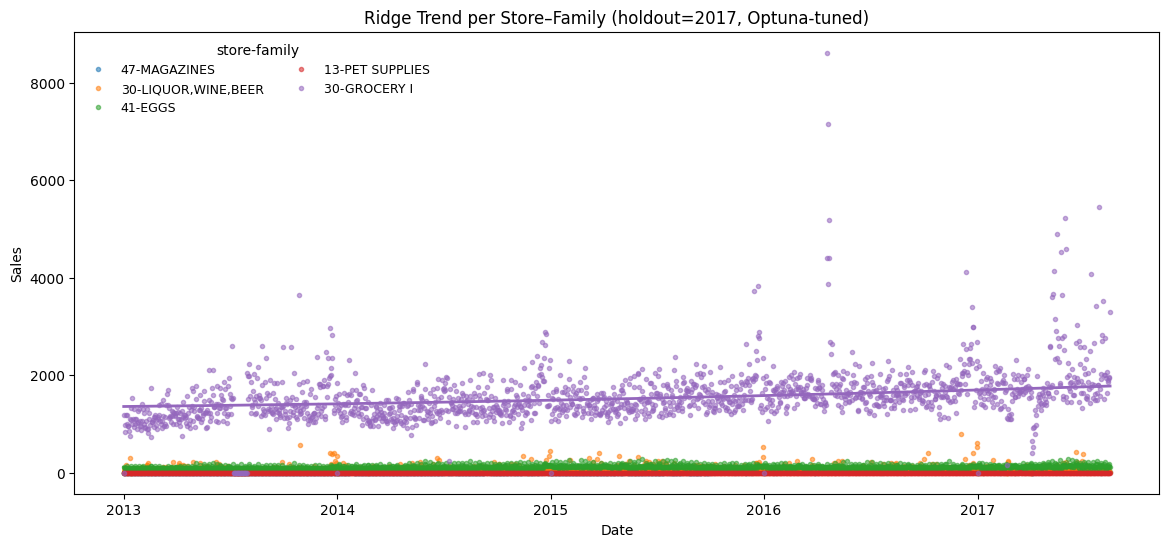

In [7]:
print("Best params:", study_trend.best_params)
print("Best RMSLE:", study_trend.best_value)
print("Best RMSE :", study_trend.best_trial.user_attrs["rmse"])

# Plot 5 random store–family combos: dots (actuals) + line (Ridge trend)
rng = np.random.default_rng(SEED)
cols = y.columns.to_list()
sel = [cols[i] for i in rng.choice(len(cols), size=5, replace=False)]

t_index = y.index.to_timestamp()
fig, ax = plt.subplots(figsize=(14, 6))
for store, fam in sel:
    series = y[(store, fam)]
    trend = y_trend[(store, fam)]
    (pts,) = ax.plot(t_index, series.values, ".", alpha=0.55, label=f"{store}-{fam}")
    ax.plot(t_index, trend.values, linewidth=2, color=pts.get_color())

ax.set_title("Ridge Trend per Store–Family (holdout=2017, Optuna-tuned)")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.legend(title="store-family", ncol=2, frameon=False, fontsize=9)
plt.show()

# Seasonality

## Build residuals (global & per-series)

In [9]:
# y and y_trend from your EN/MTEN pipeline (wide, index = Period[D], cols=(store,family))
y_resid = y - y_trend

# global daily median residual across all series
resid_median = y_resid.median(axis=1).dropna()

## Weekly seasonal plot on residuals

<Axes: title={'center': 'Seasonal Plot (week/day)'}, xlabel='day', ylabel='resid'>

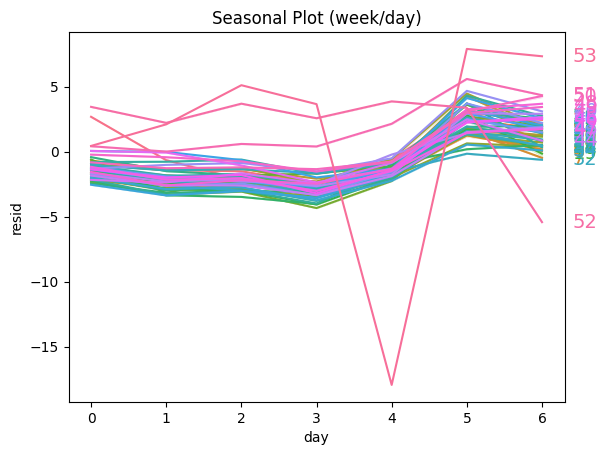

In [10]:
# Build features for the helper
s = resid_median.copy()
t = s.index.to_timestamp()

X_week = pd.DataFrame(
    {
        "week": t.isocalendar().week.astype(int).to_numpy(),
        "day": t.dayofweek.to_numpy(),
        "resid": s.to_numpy(),
    },
    index=t,
)

# Weekly seasonality: period='week', freq='day'
seasonal_plot(X_week, y="resid", period="week", freq="day")

## Periodogram on residuals (don’t double-detrend)

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

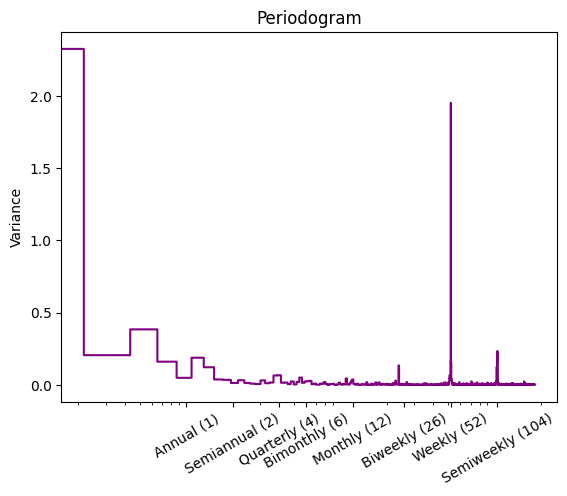

In [11]:
# For residuals, trend is already removed; use detrend='constant' (or None)
plot_periodogram(resid_median, detrend="constant")

## Fit Trend and Seasonality

In [ ]:
# Fourier + weekly seasonal DP
X_seasonal, X_forecast = make_dp(
    y.index, order=2, weekly=True, freq="A", fourier_order=12, forecast=16
)  # I will use forecast for predicting test values
ridge_seas, study_seas = fit_ridge_with_optuna(
    X_seasonal.loc[idx_train],
    y.loc[idx_train],
    X_seasonal.loc[idx_valid],
    y.loc[idx_valid],
    alpha_lo=1,
    alpha_hi=1e4,
    patience=12,
    seed=SEED,
)
y_trend = pd.DataFrame(ridge_seas.predict(X_seasonal), index=y.index, columns=y.columns)
X = X_seasonal  # keep going from this design matrix

[I 2025-08-29 19:24:54,586] A new study created in memory with name: no-name-c980a1f3-1ec6-4e0e-8958-0272bfc46f75
[I 2025-08-29 19:24:54,779] Trial 0 finished with value: 0.8289637369173827 and parameters: {'alpha': 31.489116479568608}. Best is trial 0 with value: 0.8289637369173827.
[I 2025-08-29 19:24:54,946] Trial 1 finished with value: 0.7844536980397724 and parameters: {'alpha': 6351.221010640702}. Best is trial 1 with value: 0.7844536980397724.
[I 2025-08-29 19:24:55,100] Trial 2 finished with value: 0.7896985269634238 and parameters: {'alpha': 847.1801418819975}. Best is trial 1 with value: 0.7844536980397724.
[I 2025-08-29 19:24:55,258] Trial 3 finished with value: 0.8089012810604146 and parameters: {'alpha': 248.10409748678117}. Best is trial 1 with value: 0.7844536980397724.
[I 2025-08-29 19:24:55,418] Trial 4 finished with value: 0.859872839912078 and parameters: {'alpha': 4.207988669606635}. Best is trial 1 with value: 0.7844536980397724.
[I 2025-08-29 19:24:55,570] Trial 5

[Early stop] No improvement in 12 consecutive trials. Best RMSLE so far: 0.776009


Best params: {'alpha': 2915.443189153754}
Best RMSLE: 0.7760092912575974
Best RMSE : 173.0464150890935


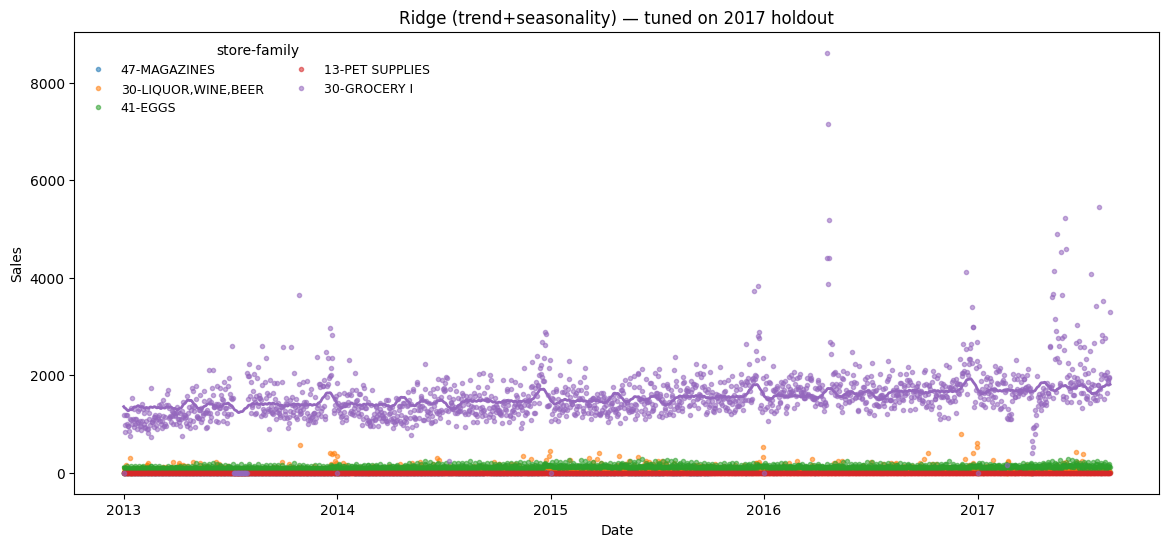

In [13]:
print("Best params:", study_seas.best_params)
print("Best RMSLE:", study_seas.best_value)
print("Best RMSE :", study_seas.best_trial.user_attrs["rmse"])

# Plot 5 random store–family combos: dots (actuals) + line (Ridge trend)
rng = np.random.default_rng(SEED)
cols = y.columns.to_list()
sel = [cols[i] for i in rng.choice(len(cols), size=5, replace=False)]

t_index = y.index.to_timestamp()
fig, ax = plt.subplots(figsize=(14, 6))
for store, fam in sel:
    series = y[(store, fam)]
    trend = y_trend[(store, fam)]
    (pts,) = ax.plot(t_index, series.values, ".", alpha=0.55, label=f"{store}-{fam}")
    ax.plot(t_index, trend.values, linewidth=2, color=pts.get_color())

ax.set_title("Ridge (trend+seasonality) — tuned on 2017 holdout")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.legend(title="store-family", ncol=2, frameon=False, fontsize=9)
plt.show()

## Check for remaining seasonality

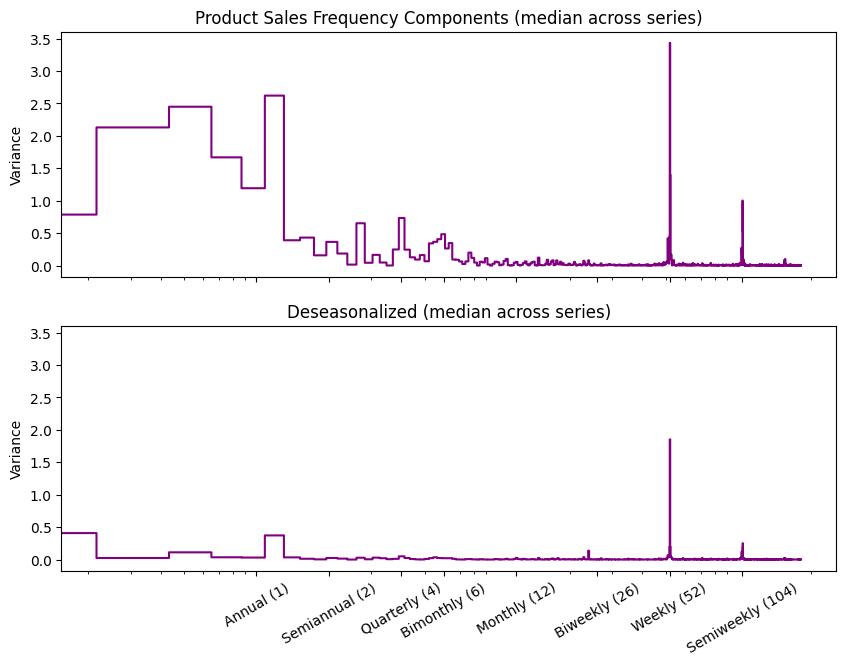

In [14]:
# y and y_trend from your EN/MTEN pipeline (wide, index = Period[D], cols=(store,family))
y_deseason = y - y_trend

# global daily median across all series
y_median = y.median(axis=1).dropna()
deseason_median = y_deseason.median(axis=1).dropna()

# For residuals, trend is already removed; use detrend='constant' (or None)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y_median, detrend="linear", ax=ax1)
ax1.set_title("Product Sales Frequency Components (median across series)")
ax2 = plot_periodogram(deseason_median, detrend="linear", ax=ax2)
ax2.set_title("Deseasonalized (median across series)");

## Handle Holidays and Other One-Hot Encodings

### Holiday Data

In [ ]:
holidays = pd.read_csv(
    f"{BASE_DIR}/holidays_events.csv",
    usecols=["date", "type", "locale", "locale_name", "description", "transferred"],
    dtype={
        "type": "category",
        "locale": "category",
        "locale_name": "category",
        "description": "category",
        "transferred": "bool",
    },
    parse_dates=["date"],
)
holidays["date"] = holidays.date.dt.to_period("D")
holidays = holidays.set_index("date").sort_index()

# Normalize description (strip leading 'Traslado ' / 'Puente ')
holidays["description"] = pd.Categorical(
    holidays["description"]
    .astype("string")
    .str.replace(r"^\s*(Traslado|Puente)\s+", "", case=False, regex=True)
)

# Keep observed dates; drop original moved dates
# (drop rows where 'transferred' is True)
holidays = holidays[~holidays["transferred"]].drop(columns="transferred")

# Collapse Transfer/Bridge to Holiday
holidays.loc[holidays["type"].isin(["Transfer", "Bridge"]), "type"] = "Holiday"

# Work Day naming
holidays["description"] = holidays["description"].cat.add_categories(["Work Day"])
holidays.loc[holidays["type"].eq("Work Day"), "description"] = "Work Day"

# Signed offsets ±N at end of description
holidays["additional"] = (
    pd.to_numeric(
        holidays["description"]
        .astype("string")
        .str.extract(r"([+-]\d+)$", expand=False),
        errors="coerce",
    )
    .fillna(0)
    .astype("int16")
)
holidays["additional_squared"] = (holidays["additional"].astype("int32") ** 2).astype(
    "int32"
)

# Strip the trailing ±N
holidays["description"] = pd.Categorical(
    holidays["description"]
    .astype("string")
    .str.replace(r"[+-]\d+$", "", regex=True)
    .str.strip()
)

# Map specific groups
holidays["description"] = holidays["description"].cat.add_categories(
    ["Shopping Day", "Disaster", "World Cup", "Local", "Regional"]
)
holidays.loc[
    holidays["description"].isin(["Cyber Monday", "Black Friday"]), "description"
] = "Shopping Day"
holidays.loc[holidays["description"].eq("Terremoto Manabi"), "description"] = "Disaster"
holidays.loc[
    holidays["description"]
    .astype("string")
    .str.contains(r"Mundial de f[uú]tbol", case=False, na=False),
    "description",
] = "World Cup"

# Collapse by locale to Local/Regional group labels
holidays.loc[holidays["locale"].eq("Local"), "description"] = "Local"
holidays.loc[holidays["locale"].eq("Regional"), "description"] = "Regional"

# Drop unused
holidays = holidays.drop(columns=["locale"])
holidays["description"] = holidays["description"].cat.remove_unused_categories()

# --- National events matrix ---
disaster = holidays.loc[holidays["description"] == "Disaster"].copy()
disaster["Disaster"] = 1.0
disaster = disaster.rename(
    columns={
        "additional": "days_from_dis",
        "additional_squared": "days_from_dis_squared",
    }
)

national = holidays.loc[
    (holidays["locale_name"] == "Ecuador") & (holidays["description"] != "Disaster")
]
national_events = pd.concat(
    [
        pd.get_dummies(
            national["description"].cat.remove_unused_categories(), dtype=float
        ),
        national[["additional", "additional_squared"]].astype(float),
    ],
    axis=1,
)
national_events = national_events.join(
    disaster[["Disaster", "days_from_dis", "days_from_dis_squared"]], how="outer"
).fillna(0.0)

# Drop duplicate dates, but keep the one with the highest absolute value of 'additional'
national_events["abs_add"] = national_events[
    "additional"
].abs()  # helper magnitude for tie-breaking
national_events = (
    national_events.reset_index()
    .sort_values(["date", "abs_add"])
    .drop_duplicates("date", keep="last")
    .drop(columns="abs_add")
    .set_index("date")
)

### Store Data

In [16]:
stores = pd.read_csv(
    f"{BASE_DIR}/stores.csv",
    usecols=["store_nbr", "city", "state", "type", "cluster"],
    dtype={
        "store_nbr": "category",
        "city": "category",
        "state": "category",
        "type": "category",
        "cluster": "category",
    },
)
stores = stores.set_index(["store_nbr"]).sort_index()
stores.head()

,city,state,type,cluster
store_nbr,,,,
1,Quito,Pichincha,D,13
10,Quito,Pichincha,C,15
11,Cayambe,Pichincha,B,6
12,Latacunga,Cotopaxi,C,15
13,Latacunga,Cotopaxi,C,15


### Incorporate National Events into Train Data

In [ ]:
X = X.join(national_events, how="left").fillna(0.0)

## Train while capturing Trend, Seasonality, and Holidays

In [ ]:
# After joining national_events (and any other features you add)
ridge_hol, study_hol = fit_ridge_with_optuna(
    X.loc[idx_train],
    y.loc[idx_train],
    X.loc[idx_valid],
    y.loc[idx_valid],
    alpha_lo=1,
    alpha_hi=1e4,
    patience=12,
    seed=SEED,
)
y_trend = pd.DataFrame(ridge_hol.predict(X), index=y.index, columns=y.columns)

[I 2025-08-29 19:24:59,097] A new study created in memory with name: no-name-07b2d23e-536f-4461-8013-19b792d86aa7
[I 2025-08-29 19:24:59,254] Trial 0 finished with value: 0.8252751008366895 and parameters: {'alpha': 31.489116479568608}. Best is trial 0 with value: 0.8252751008366895.
[I 2025-08-29 19:24:59,420] Trial 1 finished with value: 0.7847825111700937 and parameters: {'alpha': 6351.221010640702}. Best is trial 1 with value: 0.7847825111700937.
[I 2025-08-29 19:24:59,590] Trial 2 finished with value: 0.7878822076409836 and parameters: {'alpha': 847.1801418819975}. Best is trial 1 with value: 0.7847825111700937.
[I 2025-08-29 19:24:59,769] Trial 3 finished with value: 0.8056460542988442 and parameters: {'alpha': 248.10409748678117}. Best is trial 1 with value: 0.7847825111700937.
[I 2025-08-29 19:24:59,936] Trial 4 finished with value: 0.8602889390581082 and parameters: {'alpha': 4.207988669606635}. Best is trial 1 with value: 0.7847825111700937.
[I 2025-08-29 19:25:00,135] Trial 

[Early stop] No improvement in 12 consecutive trials. Best RMSLE so far: 0.775649


Best params: {'alpha': 2915.443189153754}
Best RMSLE: 0.7756489161994586
Best RMSE : 173.47640674942167


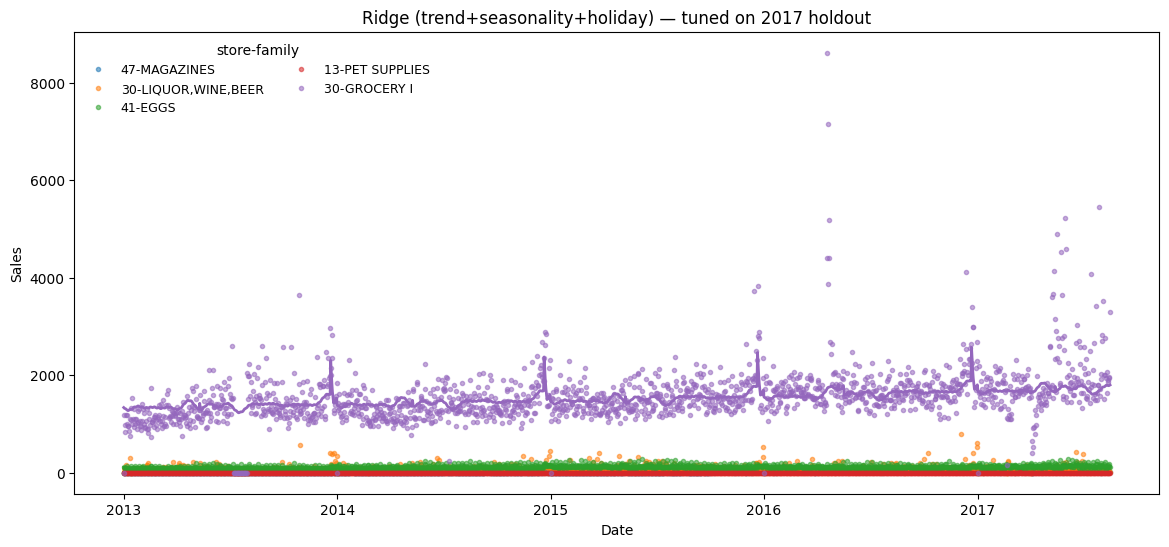

In [19]:
print("Best params:", study_hol.best_params)
print("Best RMSLE:", study_hol.best_value)
print("Best RMSE :", study_hol.best_trial.user_attrs["rmse"])

# Plot 5 random store–family combos: dots (actuals) + line (Ridge trend)
rng = np.random.default_rng(SEED)
cols = y.columns.to_list()
sel = [cols[i] for i in rng.choice(len(cols), size=5, replace=False)]

t_index = y.index.to_timestamp()
fig, ax = plt.subplots(figsize=(14, 6))
for store, fam in sel:
    series = y[(store, fam)]
    trend = y_trend[(store, fam)]
    (pts,) = ax.plot(t_index, series.values, ".", alpha=0.55, label=f"{store}-{fam}")
    ax.plot(t_index, trend.values, linewidth=2, color=pts.get_color())

ax.set_title("Ridge (trend+seasonality+holiday) — tuned on 2017 holdout")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.legend(title="store-family", ncol=2, frameon=False, fontsize=9)
plt.show()

# Cycles

## Partial Autocorrelation

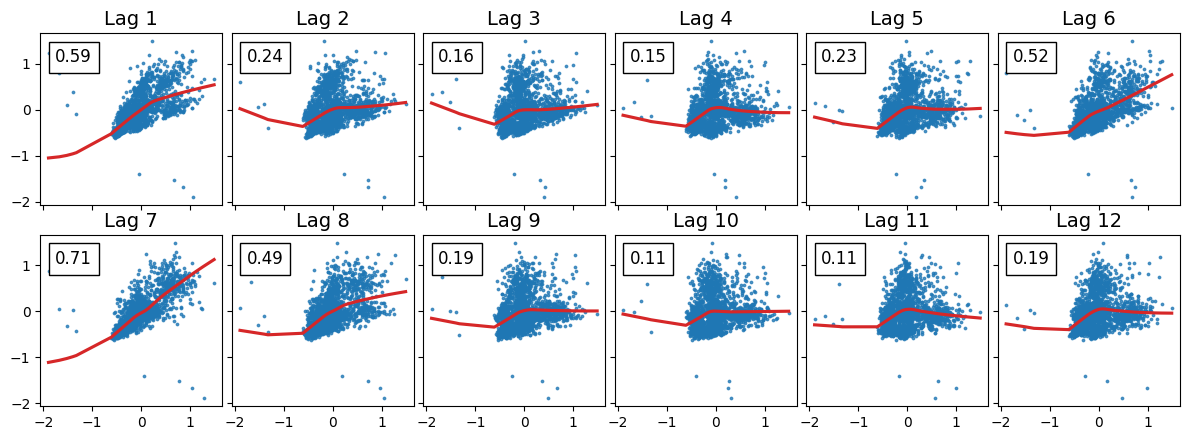

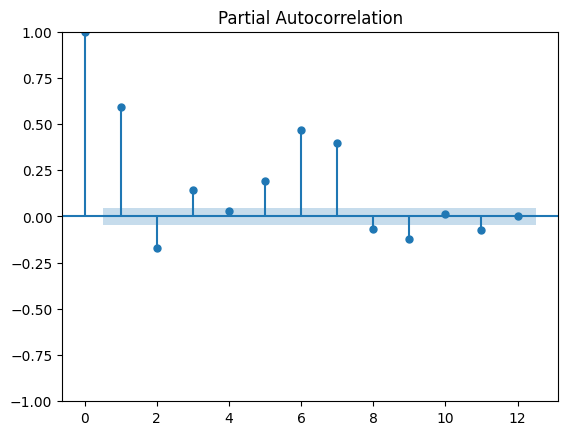

In [ ]:
# --- your y and (optionally) y_trend from the Ridge baseline ---
# y: DataFrame index=Period[D], cols MultiIndex (store_nbr, family)
# y_trend: same shape as y (trend+seasonality baseline)
# If you don't have y_trend yet, set y_resid = y.copy()

# residuals to isolate cycles (recommended)
y_resid = (y - y_trend).copy()  # remove trend/seasonality
y_resid = y_resid.replace([np.inf, -np.inf], np.nan).dropna(how="all", axis=0)

# Global standardized mean (all series)
global_cycle = zscore_cols(y_resid).mean(axis=1).dropna()
# Lag plots & PACF on the global cycle:
_ = plot_lags(global_cycle, lags=12, nrows=2)
_ = plot_pacf(global_cycle, lags=12)

In [ ]:
oil = pd.read_csv(
    f"{BASE_DIR}/oil.csv",
    usecols=["date", "dcoilwtico"],
    dtype={"dcoilwtico": "float32"},
    parse_dates=["date"],
    infer_datetime_format=True,
)
oil["date"] = oil.date.dt.to_period("D")
oil = oil.set_index("date").sort_index()
# Put on daily grid and forward-fill only (no backfill, no median fill)
oil = oil.asfreq("D")
oil["dcoilwtico"] = oil["dcoilwtico"].ffill()
oil.head()

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.139999
2013-01-03,92.970001
2013-01-04,93.120003
2013-01-07,93.199997


In [23]:
transactions = pd.read_csv(
    f"{BASE_DIR}/transactions.csv",
    usecols=["store_nbr", "transactions", "date"],
    dtype={
        "store_nbr": "category",
        "transactions": "uint32",
    },
    parse_dates=["date"],
    infer_datetime_format=True,
)
transactions["date"] = transactions.date.dt.to_period("D")
transactions = transactions.set_index(["date", "store_nbr"]).sort_index()
transactions.head()

transactions
date       store_nbr              
2013-01-01 25                  770
2013-01-02 1                  2111
           10                 1293
           11                 3547
           12                 1362

## Prep residuals (global and by store)

In [ ]:
# y: wide (date Period[D] x (store_nbr,family)); y_trend same shape
y_resid = y - y_trend
global_resid = zscore_cols(y_resid).mean(axis=1).dropna()
glob = _ensure_daily(global_resid)
store_resid = y_resid.groupby(level="store_nbr", axis=1).sum()

## CCF: Oil vs Global Sales Residual

Returns → positive at ~80 weeks: a shock in oil ~1.5 years ago lines up with higher residual sales today.

Levels → negative to ~80 then positive: levels co-trend with the deterministic terms; the sign flip at long lags is common when trend absorption differs between the two series. That’s why the returns features are often cleaner.

<Figure size 900x320 with 0 Axes>

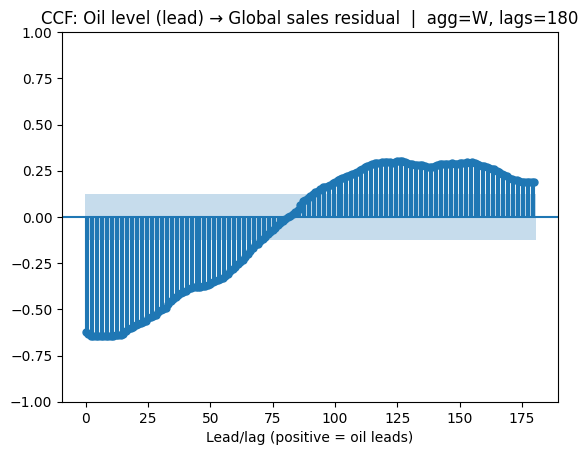

In [ ]:
# Call with longer window (26 weeks) and weekly aggregation
plot_ccf_oil_global_long(oil, glob, lags=180, agg="W", use_returns=False)

## CCF: Transactions vs Store Sales Residual

CCF is most informative per store. We’ll (a) inspect a single store, and (b) optionally summarize peak lags across all stores.

### Summarize peak CCF lags across all stores (quick grid search)

This gives, for each store, the lag in [-12, +12] with the highest absolute correlation.

[ok] Overlap: 2017-04-21 → 2017-08-15, N=117
[ok] Overlap: 2015-08-22 → 2017-08-15, N=725
[ok] Overlap: 2013-01-03 → 2017-08-15, N=1686
[ok] Overlap: 2013-01-03 → 2017-08-15, N=1686
[ok] Overlap: 2013-01-03 → 2017-08-15, N=1686
[ok] Overlap: 2013-01-03 → 2017-08-15, N=1686


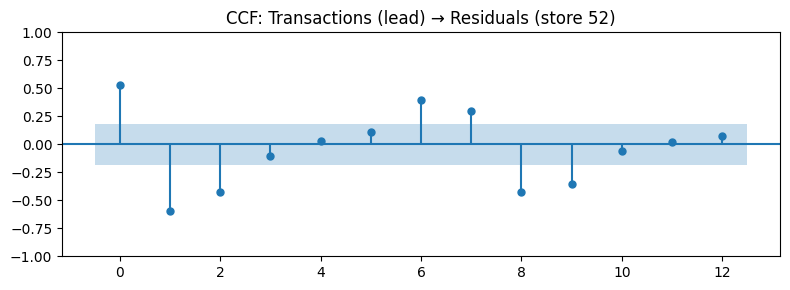

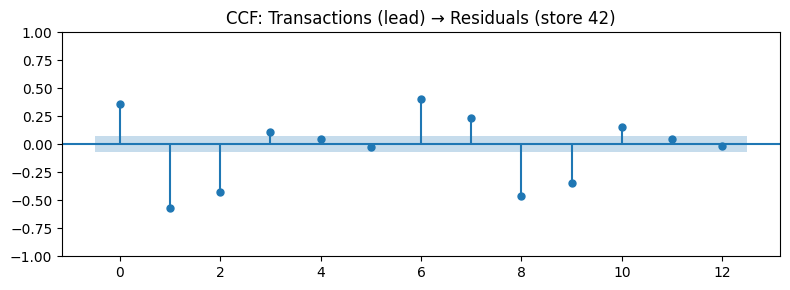

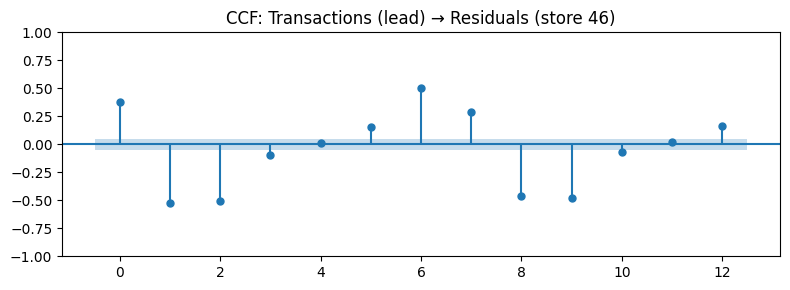

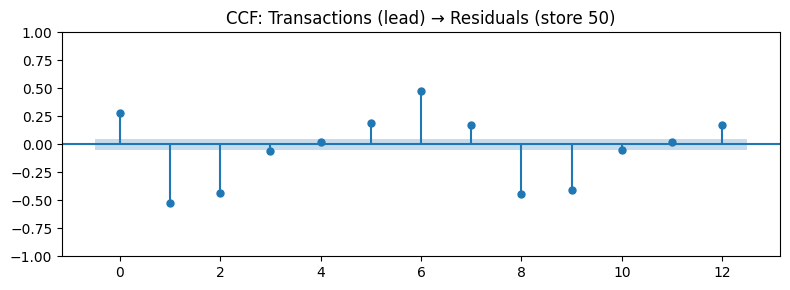

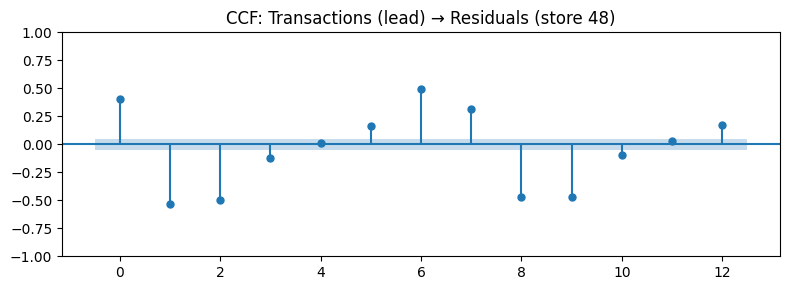

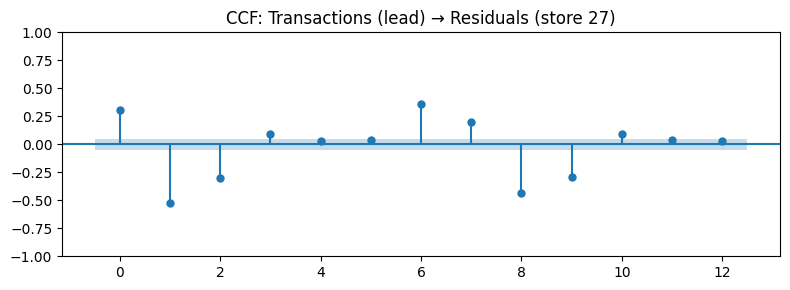

In [ ]:
ccf_summary = summarize_transactions_ccf_allstores(transactions, store_resid, lags=12)

# Take 6 representative stores (highest |corr|) and plot CCF bars
top6 = (
    ccf_summary.reindex(ccf_summary["corr"].abs().sort_values(ascending=False).index)
    .head(6)["store_nbr"]
    .tolist()
)

for s in top6:
    _ = plot_ccf_transactions_store(
        transactions, store_resid, store_id=s, lags=12
    )  # uses the robust function we wrote

## OnPromotion vs residual cycles

Treat `onpromotion` as KNOWN in the future (lead indicator). Promos are multi-day, so raw and even mildly prewhitened CCFs smear across many leads. The event-study below shows clear local bumps at +2 and a strong peak near +10. That’s a big hint for distributed-lag / exposure style features.

,store_nbr,family,best_lead,corr,n,ci95,ar_order
1404,52,GROCERY I,0,0.944020,1688,0.047706,0
1416,52,PERSONAL CARE,0,0.927653,1688,0.047706,0
1400,52,DAIRY,0,0.927511,1688,0.047706,0
1396,52,BEVERAGES,0,0.926103,1688,0.047706,0
1410,52,HOME CARE,0,0.909959,1688,0.047706,0
1399,52,CLEANING,0,0.907080,1688,0.047706,0
429,22,LAWN AND GARDEN,0,0.905510,1688,0.047706,0
1414,52,"LIQUOR,WINE,BEER",0,0.889532,1688,0.047706,0
793,33,SCHOOL AND OFFICE SUPPLIES,0,0.854774,1688,0.047706,0
1031,40,SCHOOL AND OFFICE SUPPLIES,0,0.850356,1688,0.047706,0


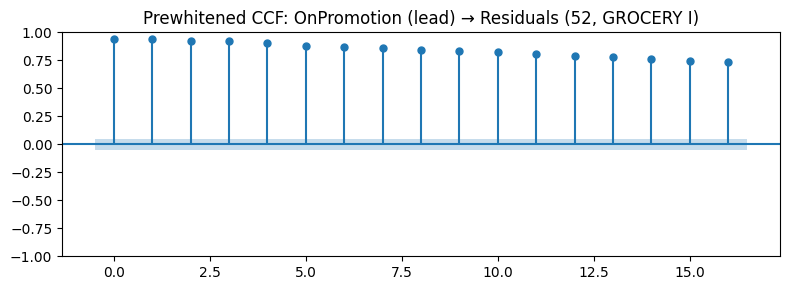

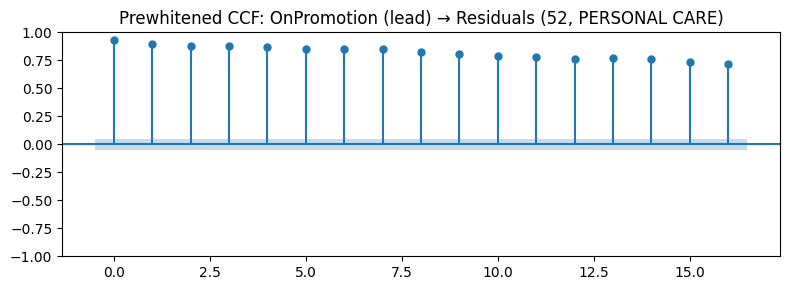

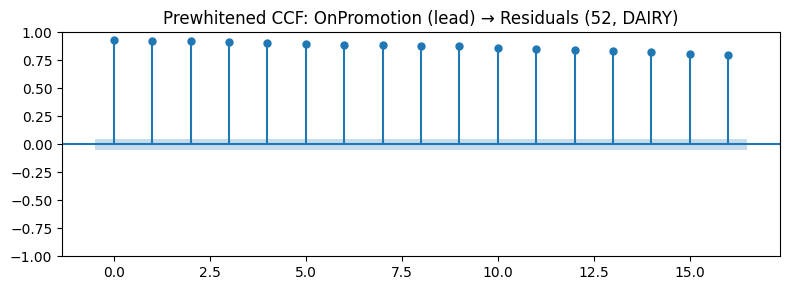

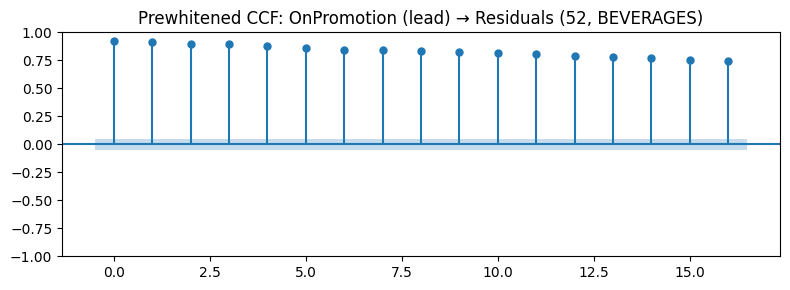

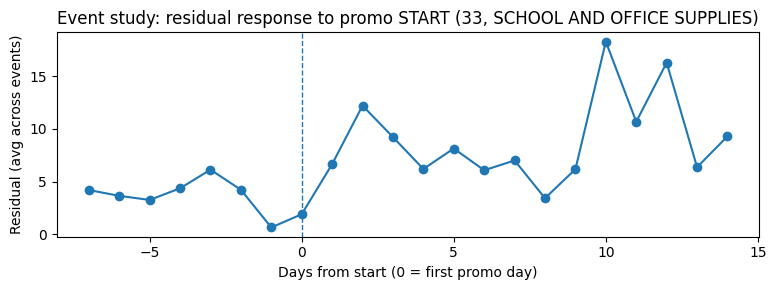

In [ ]:
# 0) Same-grain matrices (date x (store,family))
onpromo_wide = (
    store_sales["onpromotion"]
    .unstack(["store_nbr", "family"])
    .sort_index()
    .astype("float32")
    .fillna(0.0)
)
# Binary and change versions (useful for event study)
onpromo_bin = (onpromo_wide > 0).astype("float32")
onpromo_start = (onpromo_bin.astype("int8").diff() == 1).astype(
    "int8"
)  # starts where it flips 0→1

# --- Run the prewhitened summary (0..16 day leads)
onp_ccf_pw = summarize_onpromo_ccf_by_pair_prewhiten(
    y_resid, onpromo_wide, max_lead=16, max_ar=7
)
display(onp_ccf_pw.head(10))

# --- Plot top pairs to verify the peak is local (not a long decay)
for s, f in onp_ccf_pw.head(4)[["store_nbr", "family"]].itertuples(
    index=False, name=None
):
    _ = plot_ccf_onpromotion_pair_prewhiten(
        onpromo_wide, y_resid, s, f, lags=16, max_ar=7
    )

# Event-study on a strong pair (fall back to any pair with starts)
ex = None
for s, f in onp_ccf_pw[["store_nbr", "family"]].itertuples(index=False, name=None):
    if onpromo_start[(s, f)].sum() > 3:
        ex = (s, f)
        break
if ex:
    _ = event_study_onpromotion_starts(
        y_resid, onpromo_bin, ex[0], ex[1], pre_days=7, post_days=14, min_gap=7
    )

## Create Lags

I only saw cross-correlation for transactions. Oil appeared to not have any cross-correlation, so we can exclude that dataset. The cross-correlation for transactions and autocorrelation gave us a effects up to a lag of 9 for each. So I will set those here.

### Add 9 lags of sales (per store and per family)

In [ ]:
y_lag = make_lags(y, lags=9)
y_lag.columns = y_lag.columns.to_flat_index()  # Flatten the columns from 3 levels to 1
y_lag.head()

,"(y_lag_1, 1, AUTOMOTIVE)","(y_lag_1, 1, BABY CARE)","(y_lag_1, 1, BEAUTY)","(y_lag_1, 1, BEVERAGES)","(y_lag_1, 1, BOOKS)","(y_lag_1, 1, BREAD/BAKERY)","(y_lag_1, 1, CELEBRATION)","(y_lag_1, 1, CLEANING)","(y_lag_1, 1, DAIRY)","(y_lag_1, 1, DELI)",...,"(y_lag_9, 9, MAGAZINES)","(y_lag_9, 9, MEATS)","(y_lag_9, 9, PERSONAL CARE)","(y_lag_9, 9, PET SUPPLIES)","(y_lag_9, 9, PLAYERS AND ELECTRONICS)","(y_lag_9, 9, POULTRY)","(y_lag_9, 9, PREPARED FOODS)","(y_lag_9, 9, PRODUCE)","(y_lag_9, 9, SCHOOL AND OFFICE SUPPLIES)","(y_lag_9, 9, SEAFOOD)"
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,2.0,0.0,2.0,1091.0,0.0,470.652008,0.0,1060.0,579.0,164.069000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,3.0,0.0,0.0,919.0,0.0,310.654999,0.0,836.0,453.0,151.582001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-05,3.0,0.0,3.0,953.0,0.0,198.365997,0.0,827.0,460.0,131.410995,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
X = X.join(y_lag, how="left")

[I 2025-08-29 19:25:32,156] A new study created in memory with name: no-name-5c5fc067-b47f-4f95-a055-b08436658ac6
[I 2025-08-29 19:25:38,686] Trial 0 finished with value: 0.7645444724519608 and parameters: {'alpha': 56115.16415334505}. Best is trial 0 with value: 0.7645444724519608.
[I 2025-08-29 19:25:45,308] Trial 1 finished with value: 0.7666995047239199 and parameters: {'alpha': 796945.4818643926}. Best is trial 0 with value: 0.7645444724519608.
[I 2025-08-29 19:25:51,699] Trial 2 finished with value: 0.7612817608556071 and parameters: {'alpha': 291063.59131330677}. Best is trial 2 with value: 0.7612817608556071.
[I 2025-08-29 19:25:57,994] Trial 3 finished with value: 0.7592175266211051 and parameters: {'alpha': 157513.2049977971}. Best is trial 3 with value: 0.7592175266211051.
[I 2025-08-29 19:26:04,427] Trial 4 finished with value: 0.7793222750383711 and parameters: {'alpha': 20513.38263087451}. Best is trial 3 with value: 0.7592175266211051.
[I 2025-08-29 19:26:10,895] Trial 5

[Early stop] No improvement in 12 consecutive trials. Best RMSLE so far: 0.759172
Best params: {'alpha': 144957.1649157559}
Best RMSLE: 0.7591723168647443
Best RMSE : 139.61129686249555


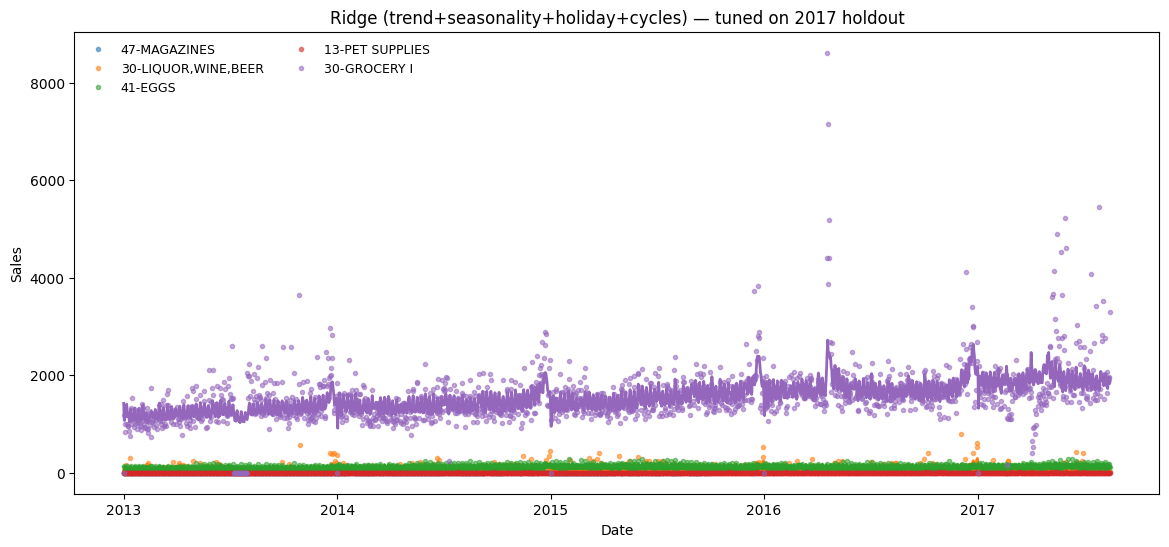

In [ ]:
# Convert column names to strings to handle error with tuples in feature names
X.columns = X.columns.astype(str)

ridge_full, study_full = fit_ridge_with_optuna(
    X.loc[idx_train],
    y.loc[idx_train],
    X.loc[idx_valid],
    y.loc[idx_valid],
    alpha_lo=1e4,
    alpha_hi=1e6,
    patience=12,
    seed=SEED,
)
y_pred_1 = pd.DataFrame(ridge_full.predict(X), index=y.index, columns=y.columns)

print("Best params:", study_full.best_params)
print("Best RMSLE:", study_full.best_value)
print("Best RMSE :", study_full.best_trial.user_attrs["rmse"])

# Freeze the TRAIN feature spaces - baseline RIDGE
BASELINE_COLS = X.columns.astype(str).tolist()  # preserve order
BASELINE_DTYPES = {c: "float32" for c in BASELINE_COLS}

# Plot a sample:
rng = np.random.default_rng(SEED)
cols = y.columns.to_list()
sel = [cols[i] for i in rng.choice(len(cols), size=5, replace=False)]

t_index = y.index.to_timestamp()
fig, ax = plt.subplots(figsize=(14, 6))
for store, fam in sel:
    series = y[(store, fam)]
    line = y_pred_1[(store, fam)]
    (pts,) = ax.plot(t_index, series.values, ".", alpha=0.55, label=f"{store}-{fam}")
    ax.plot(line.index.to_timestamp(), line.values, linewidth=2, color=pts.get_color())
ax.set_title("Ridge (trend+seasonality+holiday+cycles) — tuned on 2017 holdout")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.legend(ncol=2, frameon=False, fontsize=9)
plt.show()

### Add 9 lags of transactions (per store)

In [ ]:
transactions = transactions.unstack()

# Columns are a MultiIndex like ('transactions', store_nbr), select that slice:
tx = transactions.xs("transactions", axis=1, level=0)

dow = tx.index.dayofweek  # 0=Mon, ... 6=Sun
transactions = tx.apply(lambda c: fill_one_store(c, dow=dow), axis=0).astype("float32")

#### Transactions are skewed, apply log transform

<Axes: >

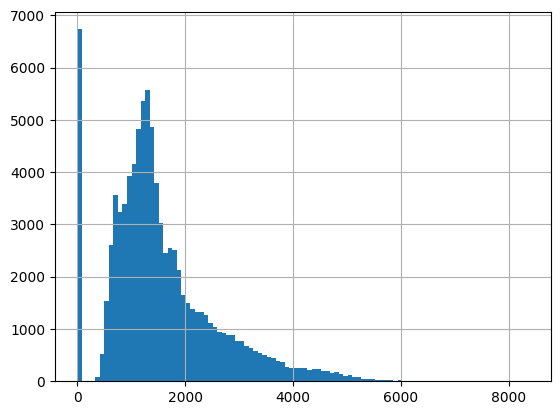

In [33]:
transactions.stack().hist(bins=100)

<Axes: >

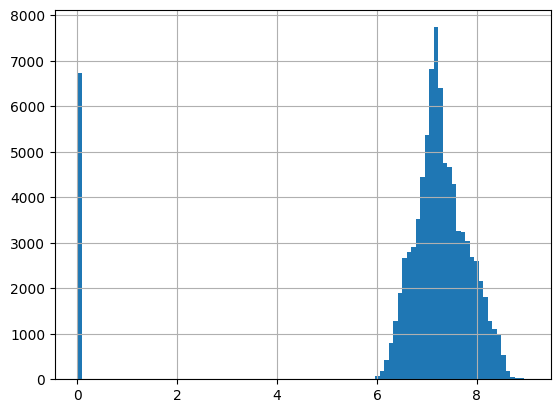

In [34]:
log_tx = np.log1p(transactions)
log_tx.stack().hist(bins=100)

In [ ]:
transactions_lag = make_lags(log_tx, lags=9, name="tx").dropna()
transactions_lag.columns = (
    transactions_lag.columns.to_flat_index()
)  # Flatten the columsn from 2 levels to 1
transactions_lag.head()

,"(tx_lag_1, 1)","(tx_lag_1, 10)","(tx_lag_1, 11)","(tx_lag_1, 12)","(tx_lag_1, 13)","(tx_lag_1, 14)","(tx_lag_1, 15)","(tx_lag_1, 16)","(tx_lag_1, 17)","(tx_lag_1, 18)",...,"(tx_lag_9, 5)","(tx_lag_9, 50)","(tx_lag_9, 51)","(tx_lag_9, 52)","(tx_lag_9, 53)","(tx_lag_9, 54)","(tx_lag_9, 6)","(tx_lag_9, 7)","(tx_lag_9, 8)","(tx_lag_9, 9)"
date,,,,,,,,,,,,,,,,,,,,,
2013-01-10,7.555382,6.836259,7.710205,7.011214,6.723833,7.372746,7.152269,6.828712,7.013016,7.095893,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-11,7.426549,6.830874,7.729735,7.022868,6.777647,7.261225,7.183871,6.791222,7.040536,7.106606,...,7.551712,8.032035,7.593878,0.0,0.0,6.906755,7.670429,7.536364,8.086718,7.986505
2013-01-12,7.503290,6.777647,7.627544,6.978214,6.716595,7.253470,7.063904,6.816736,6.894670,7.108244,...,7.462215,7.744137,7.405496,0.0,0.0,6.825460,7.493317,7.358194,7.974189,7.781973
2013-01-13,7.295735,7.021976,7.864804,7.124478,7.073270,7.570443,7.242083,6.952729,7.234177,7.104965,...,7.404279,7.900637,7.488294,0.0,0.0,6.678342,7.426549,7.322510,7.993958,7.588830
2013-01-14,6.297109,6.921658,7.964156,7.062191,6.755769,7.183871,7.023759,7.139660,7.273787,7.227663,...,7.404888,8.149024,7.634820,0.0,0.0,6.856462,7.675546,7.377759,8.026497,7.865188


In [ ]:
X = X.join(transactions_lag, how="left")

[I 2025-08-29 19:28:18,735] A new study created in memory with name: no-name-35f6aa53-a527-468a-86e4-be4636b3fe29
[I 2025-08-29 19:28:25,277] Trial 0 finished with value: 0.7644160750647981 and parameters: {'alpha': 56115.16415334505}. Best is trial 0 with value: 0.7644160750647981.
[I 2025-08-29 19:28:31,882] Trial 1 finished with value: 0.7662353694101817 and parameters: {'alpha': 796945.4818643926}. Best is trial 0 with value: 0.7644160750647981.
[I 2025-08-29 19:28:38,329] Trial 2 finished with value: 0.7607182798933947 and parameters: {'alpha': 291063.59131330677}. Best is trial 2 with value: 0.7607182798933947.
[I 2025-08-29 19:28:45,003] Trial 3 finished with value: 0.7587986506243719 and parameters: {'alpha': 157513.2049977971}. Best is trial 3 with value: 0.7587986506243719.
[I 2025-08-29 19:28:52,220] Trial 4 finished with value: 0.7796012459571343 and parameters: {'alpha': 20513.38263087451}. Best is trial 3 with value: 0.7587986506243719.
[I 2025-08-29 19:28:59,166] Trial 5

[Early stop] No improvement in 12 consecutive trials. Best RMSLE so far: 0.758723
Best params: {'alpha': 144957.1649157559}
Best RMSLE: 0.7587234118604851
Best RMSE : 139.21218817157558


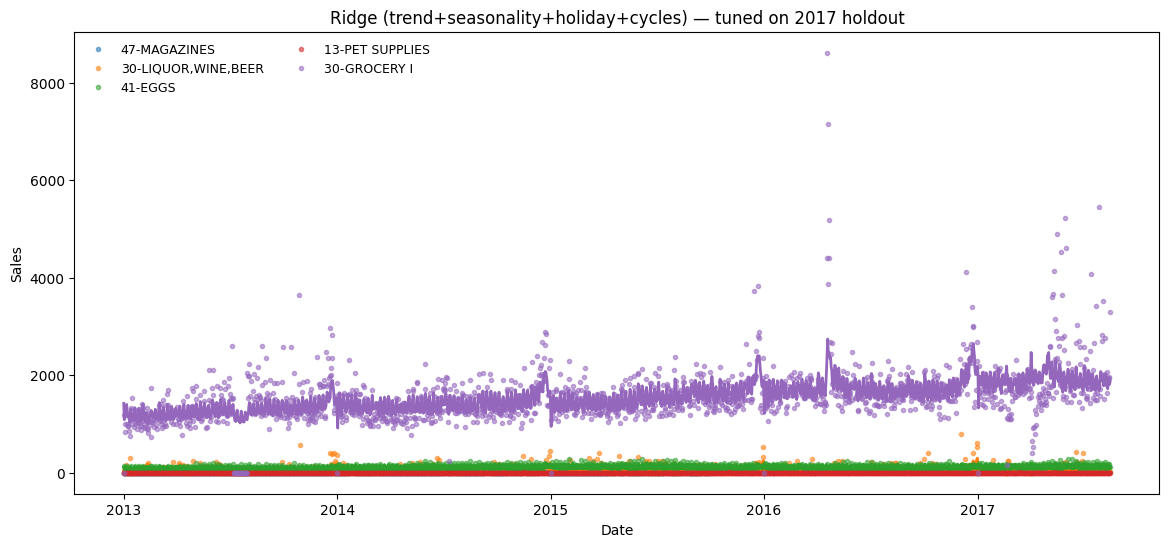

In [ ]:
# Convert column names to strings to handle error with tuples in feature names
X.columns = X.columns.astype(str)

ridge_full, study_full = fit_ridge_with_optuna(
    X.loc[idx_train],
    y.loc[idx_train],
    X.loc[idx_valid],
    y.loc[idx_valid],
    alpha_lo=1e4,
    alpha_hi=1e6,
    patience=12,
    seed=SEED,
)
y_pred_1 = pd.DataFrame(ridge_full.predict(X), index=y.index, columns=y.columns)

print("Best params:", study_full.best_params)
print("Best RMSLE:", study_full.best_value)
print("Best RMSE :", study_full.best_trial.user_attrs["rmse"])

# Freeze the TRAIN feature spaces - baseline RIDGE
BASELINE_COLS = X.columns.astype(str).tolist()  # preserve order
BASELINE_DTYPES = {c: "float32" for c in BASELINE_COLS}

# Plot a sample:
rng = np.random.default_rng(SEED)
cols = y.columns.to_list()
sel = [cols[i] for i in rng.choice(len(cols), size=5, replace=False)]

t_index = y.index.to_timestamp()
fig, ax = plt.subplots(figsize=(14, 6))
for store, fam in sel:
    series = y[(store, fam)]
    line = y_pred_1[(store, fam)]
    (pts,) = ax.plot(t_index, series.values, ".", alpha=0.55, label=f"{store}-{fam}")
    ax.plot(line.index.to_timestamp(), line.values, linewidth=2, color=pts.get_color())
ax.set_title("Ridge (trend+seasonality+holiday+cycles) — tuned on 2017 holdout")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.legend(ncol=2, frameon=False, fontsize=9)
plt.show()

### OnPromotion leads & exposure windows

The below `onpromo` blocks turned out the be large and highly-collinear. This resulted in validation RMSLE increasing. I'll let the residdual model learn the promo effect.

In [38]:
# # === OnPromotion features at (store, family) =================================
# # Source matrix: date x (store_nbr, family)
# onp_wide = (
#     store_sales["onpromotion"]
#     .unstack(["store_nbr", "family"])
#     .sort_index()
#     .astype("float32")
#     .fillna(0.0)
# )

# # Binary “on promo” indicator (for exposure windows)
# onp_bin = (onp_wide > 0).astype("float32")

# # ---- Targeted LEADS (based on event study peaks): 0..3 and 8..10 ------------
# _leads_keep = [0, 1, 2, 3, 8, 9, 10]
# onp_leads_sel = pd.concat(
#     {f"onp_lead_{k}": onp_wide.shift(-k) for k in _leads_keep},
#     axis=1
# )

# # ---- Forward EXPOSURE windows (capture sustained uplift during promo) -------
# # Helper: sum of future indicators over a [start, end] forward window
# def _sum_lead_window(df: pd.DataFrame, start: int, end: int) -> pd.DataFrame:
#     acc = None
#     for k in range(start, end + 1):
#         part = df.shift(-k)
#         acc = part if acc is None else acc.add(part, fill_value=0.0)
#     return acc

# # Short/medium/long windows guided by your event-study:
# expo_specs = {
#     "onp_expo_0_2": (0, 2),    # immediate effect (incl. +2 local max)
#     "onp_expo_3_7": (3, 7),    # mid window
#     "onp_expo_8_14": (8, 14),  # delayed effect (around +10 peak)
# }
# onp_expo = pd.concat(
#     {name: _sum_lead_window(onp_bin, a, b) for name, (a, b) in expo_specs.items()},
#     axis=1
# )

# # ---- “start” flags (0→1 flips) with short forward reach ----------
# onp_start = (onp_bin.astype("int8").diff() == 1).astype("float32")
# start_leads = pd.concat(
#     {f"onp_start_lead_{k}": onp_start.shift(-k) for k in [0, 1, 2]},
#     axis=1
# )

# # ---- Assemble features, flatten columns, join to design matrix --------------
# onp_feats_wide = pd.concat([onp_leads_sel, onp_expo, start_leads], axis=1)

# # Keep index as Period[D] to match X; ensure consistent dtype and names
# onp_feats_wide = onp_feats_wide.astype("float32")
# onp_feats_wide.columns = onp_feats_wide.columns.to_flat_index()  # flatten MultiIndex

# # Join into your cycles matrix (this is the same pattern you used for y_lag/tx_lag)
# X = X.join(onp_feats_wide, how="left").fillna(0.0)

### Add long term oil lag features

In [ ]:
# --- Oil long-lag features (date-indexed, shared across all series) ----------
# Build on the notebook's daily timeline (timestamps), then convert back to Period[D]
daily_idx = y.index.to_timestamp()
oil_feats_daily = make_oil_weekly_features(
    oil, daily_idx, lag_weeks=(78, 80, 84), include_levels=True, include_returns=True
)

# Convert to Period[D] so it joins cleanly to X
oil_feats = oil_feats_daily.copy()
oil_feats.index = oil_feats.index.to_period("D")

# Join (small set, so fine for Ridge); fill only after join to avoid alignment holes
X = X.join(oil_feats, how="left").fillna(0.0)

## Train on Lag Features

This is our final training before sending it over to model 2, XGBoost.

[I 2025-08-29 19:31:15,108] A new study created in memory with name: no-name-173fb36a-e8ba-41bd-9595-52a066fb4a33
[I 2025-08-29 19:31:21,625] Trial 0 finished with value: 0.7640525774652507 and parameters: {'alpha': 56115.16415334505}. Best is trial 0 with value: 0.7640525774652507.
[I 2025-08-29 19:31:28,032] Trial 1 finished with value: 0.7664725282667787 and parameters: {'alpha': 796945.4818643926}. Best is trial 0 with value: 0.7640525774652507.
[I 2025-08-29 19:31:34,513] Trial 2 finished with value: 0.7606410678894384 and parameters: {'alpha': 291063.59131330677}. Best is trial 2 with value: 0.7606410678894384.
[I 2025-08-29 19:31:41,022] Trial 3 finished with value: 0.7584606812199898 and parameters: {'alpha': 157513.2049977971}. Best is trial 3 with value: 0.7584606812199898.
[I 2025-08-29 19:31:47,532] Trial 4 finished with value: 0.7802999178021155 and parameters: {'alpha': 20513.38263087451}. Best is trial 3 with value: 0.7584606812199898.
[I 2025-08-29 19:31:53,888] Trial 5

[Early stop] No improvement in 12 consecutive trials. Best RMSLE so far: 0.758364
Best params: {'alpha': 144957.1649157559}
Best RMSLE: 0.7583640085970339
Best RMSE : 139.32475620312454


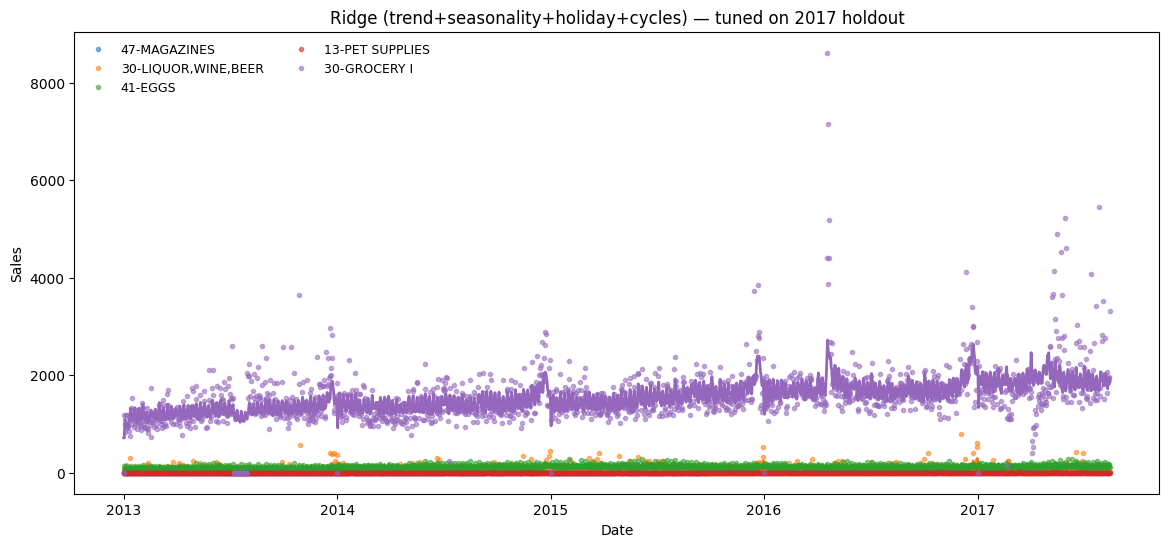

In [ ]:
# Convert column names to strings to handle error with tuples in feature names
X.columns = X.columns.astype(str)

ridge_full, study_full = fit_ridge_with_optuna(
    X.loc[idx_train],
    y.loc[idx_train],
    X.loc[idx_valid],
    y.loc[idx_valid],
    alpha_lo=1e4,
    alpha_hi=1e6,
    patience=12,
    seed=SEED,
)
y_pred_1 = pd.DataFrame(ridge_full.predict(X), index=y.index, columns=y.columns)

print("Best params:", study_full.best_params)
print("Best RMSLE:", study_full.best_value)
print("Best RMSE :", study_full.best_trial.user_attrs["rmse"])

# Freeze the TRAIN feature spaces - baseline RIDGE
BASELINE_COLS = X.columns.astype(str).tolist()  # preserve order
BASELINE_DTYPES = {c: "float32" for c in BASELINE_COLS}

# Plot a sample:
rng = np.random.default_rng(SEED)
cols = y.columns.to_list()
sel = [cols[i] for i in rng.choice(len(cols), size=5, replace=False)]

t_index = y.index.to_timestamp()
fig, ax = plt.subplots(figsize=(14, 6))
for store, fam in sel:
    series = y[(store, fam)]
    line = y_pred_1[(store, fam)]
    (pts,) = ax.plot(t_index, series.values, ".", alpha=0.55, label=f"{store}-{fam}")
    ax.plot(line.index.to_timestamp(), line.values, linewidth=2, color=pts.get_color())
ax.set_title("Ridge (trend+seasonality+holiday+cycles) — tuned on 2017 holdout")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.legend(ncol=2, frameon=False, fontsize=9)
plt.show()

#  Train XGBoost on Residuals for Hybrid Model

## Get Residuals

In [ ]:
resid_df = (y - y_pred_1).stack(["store_nbr", "family"]).rename("Residuals").to_frame()
resid_df.head()

Residuals
date       store_nbr family                
2013-01-01 1         AUTOMOTIVE   -1.678937
                     BABY CARE     0.000000
                     BEAUTY       -1.499990
                     BEVERAGES  -692.932577
                     BOOKS         0.076396

## Get Target

In [ ]:
y2 = resid_df["Residuals"]
y2.head()

date        store_nbr  family    
2013-01-01  1          AUTOMOTIVE     -1.678937
                       BABY CARE       0.000000
                       BEAUTY         -1.499990
                       BEVERAGES    -692.932577
                       BOOKS           0.076396
Name: Residuals, dtype: float64

## Get Features (X2)

In [ ]:
X2 = resid_df.drop(columns=["Residuals"])
X2.head()

Empty DataFrame
Columns: []
Index: [(2013-01-01, 1, AUTOMOTIVE), (2013-01-01, 1, BABY CARE), (2013-01-01, 1, BEAUTY), (2013-01-01, 1, BEVERAGES), (2013-01-01, 1, BOOKS)]

### Add Store Type and Cluster

In [ ]:
X2 = X2.join(stores, on="store_nbr", how="left")
X2.head()

city      state type cluster
date       store_nbr family                                   
2013-01-01 1         AUTOMOTIVE  Quito  Pichincha    D      13
                     BABY CARE   Quito  Pichincha    D      13
                     BEAUTY      Quito  Pichincha    D      13
                     BEVERAGES   Quito  Pichincha    D      13
                     BOOKS       Quito  Pichincha    D      13

### Add Local & Regional Holidays

In [ ]:
local_holidays = build_local_table(holidays)
regional_holidays = build_regional_table(holidays)

# Add local
X2 = (
    X2.reset_index()
    .merge(
        local_holidays.reset_index(),
        on=["date", "city"],
        how="left",
        validate="many_to_one",
    )
    .set_index("date")
    .drop("city", axis=1)
)
X2 = X2.fillna({"additional": 0.0, "additional_squared": 0.0, "local_holiday": 0.0})

# Add regional
X2 = (
    X2.reset_index()
    .merge(
        regional_holidays.reset_index(),
        on=["date", "state"],
        how="left",
        validate="many_to_one",
    )
    .set_index("date")
    .drop("state", axis=1)
)
X2 = X2.fillna({"regional_holiday": 0.0})
X2.head()

,store_nbr,family,type,cluster,additional,additional_squared,local_holiday,regional_holiday
date,,,,,,,,
2013-01-01,1,AUTOMOTIVE,D,13,0.0,0.0,0.0,0.0
2013-01-01,1,BABY CARE,D,13,0.0,0.0,0.0,0.0
2013-01-01,1,BEAUTY,D,13,0.0,0.0,0.0,0.0
2013-01-01,1,BEVERAGES,D,13,0.0,0.0,0.0,0.0
2013-01-01,1,BOOKS,D,13,0.0,0.0,0.0,0.0


### Encode Features

In [ ]:
family_one_hot = pd.get_dummies(X2["family"], drop_first=True, dtype=float)
store_nbr_one_hot = pd.get_dummies(
    X2["store_nbr"], prefix="store_nbr_", drop_first=True, dtype=float
)
type_one_hot = pd.get_dummies(X2["type"], prefix="type_", drop_first=True, dtype=float)
cluster_one_hot = pd.get_dummies(
    X2["cluster"], prefix="cluster", drop_first=True, dtype=float
)

# Build “global” categories from training data
FAMILY_CATS = pd.Index(y.columns.get_level_values("family").unique(), name="family")
STORE_CATS = pd.Index(
    y.columns.get_level_values("store_nbr").unique(), name="store_nbr"
)
TYPE_CATS = stores["type"].astype("category").cat.categories
CLUSTER_CATS = stores["cluster"].astype("category").cat.categories

X2 = pd.concat(
    [X2, family_one_hot, store_nbr_one_hot, type_one_hot, cluster_one_hot], axis=1
).drop(["type", "cluster"], axis=1)
X2.head()

,store_nbr,family,additional,additional_squared,local_holiday,regional_holiday,BABY CARE,BEAUTY,BEVERAGES,BOOKS,...,cluster_16,cluster_17,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,1,BABY CARE,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,1,BEAUTY,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,1,BEVERAGES,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,1,BOOKS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Add in a compact set of `onpromotion` features

I took `onpromotion` features out of the Ridge model since it increase RMSLE. Adding them in here for the residual model, XGB.

In [ ]:
onp_long = create_onpromo_feat(store_sales)

# --- Merge compact promo features into X2 (cheap: +3 columns) --------------
X2 = (
    X2.reset_index()
    .merge(
        onp_long.reset_index(),
        on=["date", "store_nbr", "family"],
        how="left",
        validate="many_to_one",
    )
    .set_index(["date", "store_nbr", "family"])
)

In [ ]:
# Baseline (Ridge) predictions in long form
y1_long = (
    y_pred_1.stack(["store_nbr", "family"])
    .rename("Baseline")
    .reorder_levels(["date", "store_nbr", "family"])
    .sort_index()
)

# Ground-truth in long form
y_long = (
    y.stack(["store_nbr", "family"])
    .rename("sales")
    .reorder_levels(["date", "store_nbr", "family"])
    .sort_index()
)

# Residual target for the residual model
y2 = (y_long - y1_long).rename("Residuals")

# --- Guardrails: make sure indices are clean and aligned ----------------------
for name, obj in [("X2", X2), ("y2", y2), ("y1_long", y1_long), ("y_long", y_long)]:
    assert list(obj.index.names) == ["date", "store_nbr", "family"], (
        f"{name} index must be (date, store_nbr, family)"
    )
    assert obj.index.is_unique, (
        f"{name} has duplicate index rows; fix merges/dedup first"
    )

# Align X2 and y2 to the exact same keys (intersection) to avoid stray rows
common = X2.index.intersection(y2.index)
X2 = X2.loc[common].sort_index()
y2 = y2.loc[common].sort_index()

# --- Time split using the 'date' level ---------------------------------------
cutoff = pd.Period("2017-01-01", freq="D")
date_idx = X2.index.get_level_values("date")

idx_train = date_idx < cutoff
idx_valid = ~idx_train

X2_train, y2_train = X2[idx_train], y2[idx_train]
X2_valid, y2_valid = X2[idx_valid], y2[idx_valid]

# Baseline and truth on the *same* rows as y2_valid:
y1_valid = y1_long.loc[y2_valid.index]
y_valid = y_long.loc[y2_valid.index]

# --- XGB on residuals ---
model = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    n_jobs=-1,
    tree_method="hist",
    random_state=SEED,
)

model.fit(
    X2_train,
    y2_train,
    eval_set=[(X2_valid, y2_valid)],
    eval_metric="rmse",
    early_stopping_rounds=100,
    verbose=False,
)

# --- Validation metrics (corrected) ---
y2_valid_pred = pd.Series(
    model.predict(X2_valid), index=X2_valid.index, name="res2_valid"
)
y_valid_pred = (y1_valid + y2_valid_pred).clip(lower=0)

print(
    "Baseline RMSLE:",
    (mean_squared_log_error(y_valid.clip(lower=0), y1_valid.clip(lower=0)) ** 0.5),
)
print(
    "Hybrid   RMSLE:",
    (mean_squared_log_error(y_valid.clip(lower=0), y_valid_pred) ** 0.5),
)

# --- Retrain residual model on FULL data -------------------------------------
best_n = getattr(model, "best_iteration", None) or model.n_estimators
final_model = XGBRegressor(
    n_estimators=best_n,
    learning_rate=model.get_xgb_params()["learning_rate"],
    max_depth=model.get_xgb_params()["max_depth"],
    subsample=model.get_xgb_params()["subsample"],
    colsample_bytree=model.get_xgb_params()["colsample_bytree"],
    reg_lambda=model.get_xgb_params()["reg_lambda"],
    n_jobs=-1,
    tree_method=model.get_xgb_params().get("tree_method", "hist"),
    random_state=SEED,
)
final_model.fit(X2, y2)
print(f"Trained final residual model with n_estimators={best_n}.")

# Residual predictions on FULL index (train+valid)
y2_full_pred = pd.Series(final_model.predict(X2), index=X2.index, name="Res2")

# --- Combine baseline + residual (indices match exactly) ----------------------
# If shapes differ, reindex; but with the guardrails above they should be identical.
y_pred_long = (
    (y1_long.loc[y2_full_pred.index] + y2_full_pred).rename("sales").clip(lower=0)
)

# Freeze the TRAIN feature spaces - residual
RESIDUAL_COLS = X2.columns.astype(str).tolist()  # preserve order
RESIDUAL_DTYPES = {c: "float32" for c in RESIDUAL_COLS}
print("\nBaseline features:", len(BASELINE_COLS))
print("Residual features:", len(RESIDUAL_COLS))

Baseline RMSLE: 0.7583640085970341
Hybrid   RMSLE: 0.7194696318981867
Trained final residual model with n_estimators=367.

Baseline features: 16582
Residual features: 112


# Submission

## Load Test Data

In [ ]:
test = pd.read_csv(
    f"{BASE_DIR}/test.csv",
    dtype={
        "id": "uint32",
        "store_nbr": "category",
        "family": "category",
        "onpromotion": "uint32",
    },
    parse_dates=["date"],
    infer_datetime_format=True,
)
test["date"] = test.date.dt.to_period("D")
test = test.set_index(["store_nbr", "family", "date"]).sort_index()

In [ ]:
(store_sales["sales"] == 0).mean()

0.3129506999261552

In [ ]:
store_sales["sales"].describe(percentiles=[0.5, 0.9, 0.99, 0.999])

count    3.000888e+06
mean     3.577757e+02
std      1.093276e+03
min      0.000000e+00
50%      1.100000e+01
90%      8.670000e+02
99%      5.507000e+03
99.9%    1.207623e+04
max      1.247170e+05
Name: sales, dtype: float64

## Predict Transactions

Transaction lag was a predictive feature during training, but we don't have that
data. We need to fit the transaction training data's trend and seasonality to
project 16 data points for test.

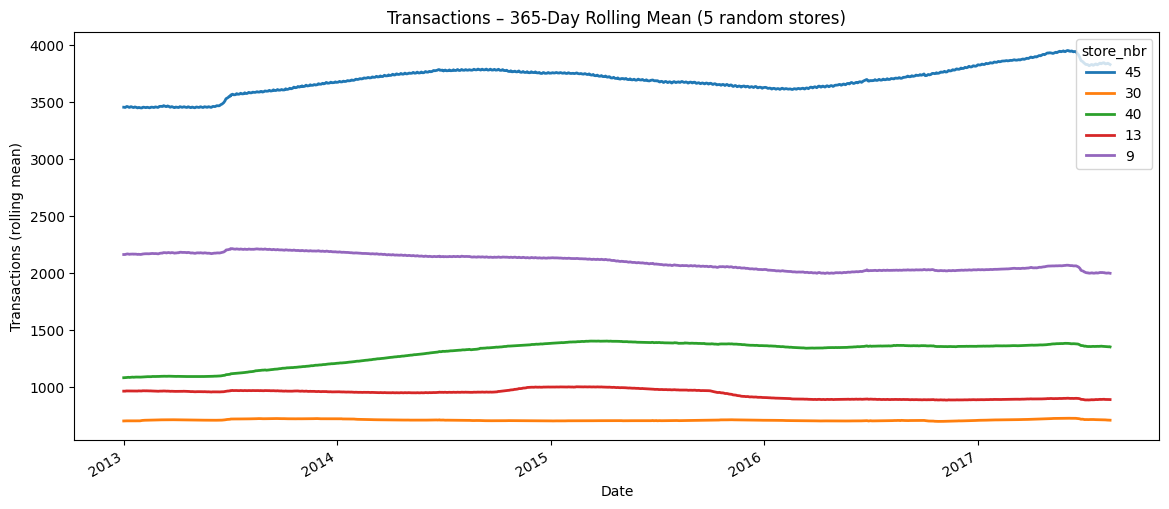

In [52]:
# Sample 5 random stores
store_cols = transactions.columns  # wide: index=date, columns=store_nbr
rng = np.random.default_rng(42)
sel_stores = store_cols.take(rng.choice(len(store_cols), size=5, replace=False))

# Slice stores
to_plot = transactions.loc[:, sel_stores].copy()
to_plot.index = to_plot.index.to_timestamp()

# 365-day centered rolling mean
ma365 = to_plot.rolling(window=365, center=True, min_periods=183).mean()

# Plot
ax = ma365.plot(figsize=(14, 6), linewidth=2, legend=True)
ax.set_title("Transactions – 365-Day Rolling Mean (5 random stores)")
ax.set_xlabel("Date")
ax.set_ylabel("Transactions (rolling mean)")
plt.show()

### Build wide target (y_tx) and fit trend only

In [ ]:
y_tx = make_wide_transactions(transactions)
# Deterministic trend (no weekly yet)
X_tx = make_dp(y_tx.index, order=2, weekly=False)

# Split
idx_train_tx = y_tx.index < "2017-01-01"
idx_valid_tx = ~idx_train_tx

# Trend-only Ridge
ridge_trend_tx, study_trend_tx = fit_ridge_with_optuna(
    X_tx.loc[idx_train_tx],
    y_tx.loc[idx_train_tx],
    X_tx.loc[idx_valid_tx],
    y_tx.loc[idx_valid_tx],
    alpha_lo=1e3,
    alpha_hi=1e4,
    patience=12,
    seed=SEED,
)
y_trend_tx = pd.DataFrame(
    ridge_trend_tx.predict(X_tx), index=y_tx.index, columns=y_tx.columns
)

print("Best params:", study_trend_tx.best_params)
print("Best RMSLE:", study_trend_tx.best_value)
print("Best RMSE :", study_trend_tx.best_trial.user_attrs["rmse"])

[I 2025-08-29 19:42:37,034] A new study created in memory with name: no-name-5a5fa52b-16b0-4984-af84-8bfd47e2c336
[I 2025-08-29 19:42:37,057] Trial 0 finished with value: 0.776369457857892 and parameters: {'alpha': 2368.863950364079}. Best is trial 0 with value: 0.776369457857892.
[I 2025-08-29 19:42:37,074] Trial 1 finished with value: 0.7921575904968517 and parameters: {'alpha': 8927.180304353626}. Best is trial 0 with value: 0.776369457857892.
[I 2025-08-29 19:42:37,091] Trial 2 finished with value: 0.7834634957394851 and parameters: {'alpha': 5395.030966670228}. Best is trial 0 with value: 0.776369457857892.
[I 2025-08-29 19:42:37,109] Trial 3 finished with value: 0.7797003179166173 and parameters: {'alpha': 3968.7933304443736}. Best is trial 0 with value: 0.776369457857892.
[I 2025-08-29 19:42:37,126] Trial 4 finished with value: 0.7760789044727244 and parameters: {'alpha': 1432.2493718230244}. Best is trial 4 with value: 0.7760789044727244.
[I 2025-08-29 19:42:37,143] Trial 5 fin

[Early stop] No improvement in 12 consecutive trials. Best RMSLE so far: 0.775926
Best params: {'alpha': 1752.9052311009261}
Best RMSLE: 0.7759263708683952
Best RMSE : 272.0328943986473


### Residuals, weekly seasonal plot, and periodogram

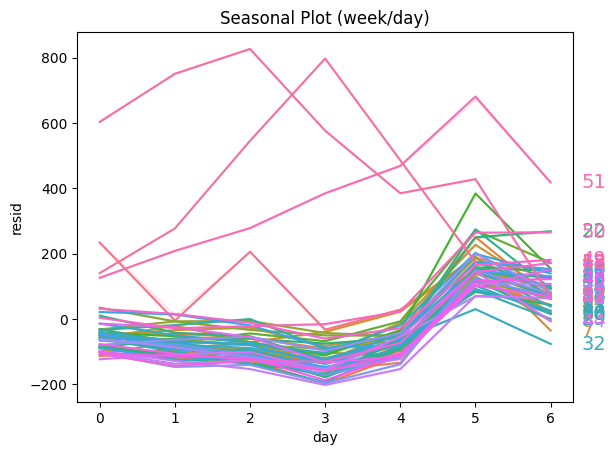

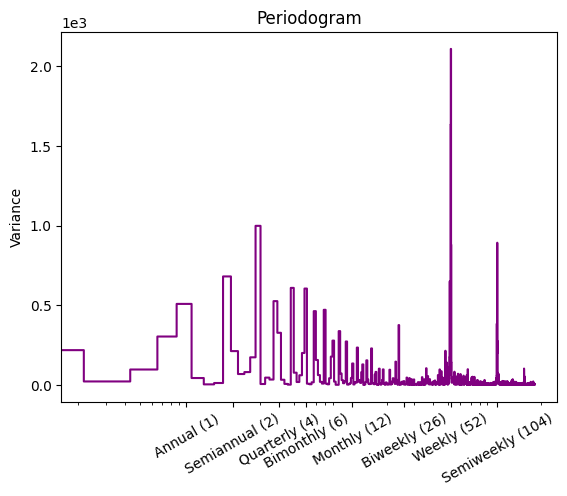

In [ ]:
# Residuals
y_resid_tx = (
    (y_tx - y_trend_tx).replace([np.inf, -np.inf], np.nan).dropna(how="all", axis=0)
)

# Global (median across stores) residual
resid_median_tx = y_resid_tx.median(axis=1).dropna()
t_tx = resid_median_tx.index.to_timestamp()

# Weekly seasonal plot on residuals
X_week_tx = pd.DataFrame(
    {
        "week": t_tx.isocalendar().week.astype(int).to_numpy(),
        "day": t_tx.dayofweek.to_numpy(),
        "resid": resid_median_tx.to_numpy(),
    },
    index=t_tx,
)
seasonal_plot(X_week_tx, y="resid", period="week", freq="day")

# Periodogram of residuals (don’t double-detrend)
_ = plot_periodogram(resid_median_tx, detrend="constant")

### Fit trend + seasonality, keep seasonal DP as the base design

In [ ]:
# Fourier + weekly seasonal DP
X_seasonal_tx, X_tx_forecast = make_dp(
    y_tx.index, order=2, weekly=True, fourier_order=12, forecast=16
)
ridge_seas_tx, study_seas_tx = fit_ridge_with_optuna(
    X_seasonal_tx.loc[idx_train_tx],
    y_tx.loc[idx_train_tx],
    X_seasonal_tx.loc[idx_valid_tx],
    y_tx.loc[idx_valid_tx],
    alpha_lo=1e3,
    alpha_hi=1e4,
    patience=12,
    seed=SEED,
)
y_trend_tx = pd.DataFrame(
    ridge_seas_tx.predict(X_seasonal_tx), index=y_tx.index, columns=y_tx.columns
)
X_tx = X_seasonal_tx

print("Best params:", study_seas_tx.best_params)
print("Best RMSLE:", study_seas_tx.best_value)
print("Best RMSE :", study_seas_tx.best_trial.user_attrs["rmse"])

[I 2025-08-29 19:42:44,487] A new study created in memory with name: no-name-1d006fc7-31a2-44db-863f-f59011e9b333
[I 2025-08-29 19:42:44,528] Trial 0 finished with value: 0.7764664139810646 and parameters: {'alpha': 2368.863950364079}. Best is trial 0 with value: 0.7764664139810646.
[I 2025-08-29 19:42:44,571] Trial 1 finished with value: 0.7929815243773137 and parameters: {'alpha': 8927.180304353626}. Best is trial 0 with value: 0.7764664139810646.
[I 2025-08-29 19:42:44,611] Trial 2 finished with value: 0.7841145927536302 and parameters: {'alpha': 5395.030966670228}. Best is trial 0 with value: 0.7764664139810646.
[I 2025-08-29 19:42:44,651] Trial 3 finished with value: 0.780161678337176 and parameters: {'alpha': 3968.7933304443736}. Best is trial 0 with value: 0.7764664139810646.
[I 2025-08-29 19:42:44,701] Trial 4 finished with value: 0.7759415336562534 and parameters: {'alpha': 1432.2493718230244}. Best is trial 4 with value: 0.7759415336562534.
[I 2025-08-29 19:42:44,791] Trial 5

[Early stop] No improvement in 12 consecutive trials. Best RMSLE so far: 0.775848
Best params: {'alpha': 1709.3285921597987}
Best RMSLE: 0.7758479983884995
Best RMSE : 269.79667019769033


### Incorporate National Events

In [ ]:
# national_events index: Period[D]
X_tx = X_tx.join(national_events, how="left").fillna(0.0)

# Refit with holidays to capture their effect
ridge_hol_tx, study_hol_tx = fit_ridge_with_optuna(
    X_tx.loc[idx_train_tx],
    y_tx.loc[idx_train_tx],
    X_tx.loc[idx_valid_tx],
    y_tx.loc[idx_valid_tx],
    alpha_lo=1e3,
    alpha_hi=1e4,
    patience=12,
    seed=SEED,
)
y_trend_tx = pd.DataFrame(
    ridge_hol_tx.predict(X_tx), index=y_tx.index, columns=y_tx.columns
)

print("Best params:", study_hol_tx.best_params)
print("Best RMSLE:", study_hol_tx.best_value)
print("Best RMSE :", study_hol_tx.best_trial.user_attrs["rmse"])

[I 2025-08-29 19:42:46,345] A new study created in memory with name: no-name-b43bf0b6-33d5-4e20-aa78-7ab95bcb22a7
[I 2025-08-29 19:42:46,394] Trial 0 finished with value: 0.7765285688430599 and parameters: {'alpha': 2368.863950364079}. Best is trial 0 with value: 0.7765285688430599.
[I 2025-08-29 19:42:46,446] Trial 1 finished with value: 0.7933656560852927 and parameters: {'alpha': 8927.180304353626}. Best is trial 0 with value: 0.7765285688430599.
[I 2025-08-29 19:42:46,498] Trial 2 finished with value: 0.7844475490028092 and parameters: {'alpha': 5395.030966670228}. Best is trial 0 with value: 0.7765285688430599.
[I 2025-08-29 19:42:46,544] Trial 3 finished with value: 0.7804157792024736 and parameters: {'alpha': 3968.7933304443736}. Best is trial 0 with value: 0.7765285688430599.
[I 2025-08-29 19:42:46,592] Trial 4 finished with value: 0.775798226322708 and parameters: {'alpha': 1432.2493718230244}. Best is trial 4 with value: 0.775798226322708.
[I 2025-08-29 19:42:46,639] Trial 5 

[Early stop] No improvement in 12 consecutive trials. Best RMSLE so far: 0.775753
Best params: {'alpha': 1607.5462249755433}
Best RMSLE: 0.775753277082573
Best RMSE : 268.6625620784426


### PACF on residuals (to choose lags)

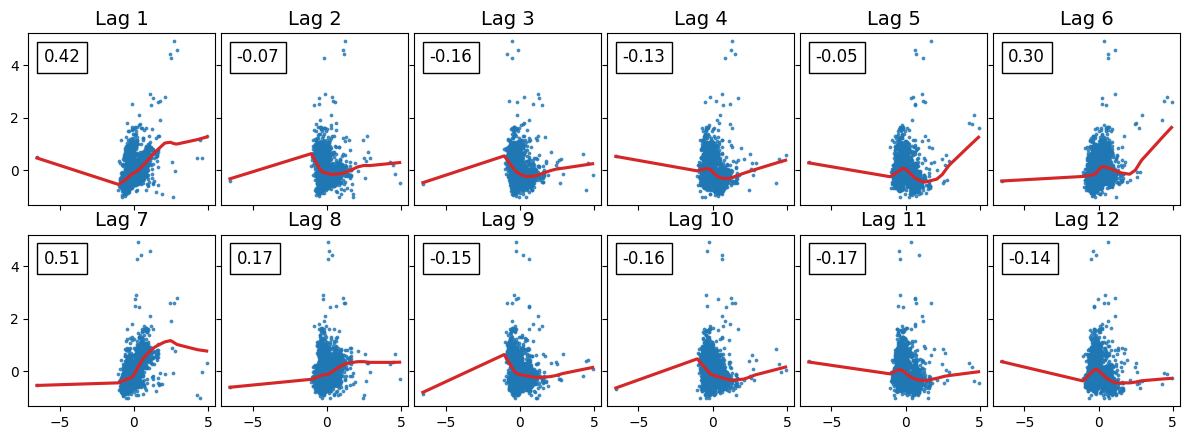

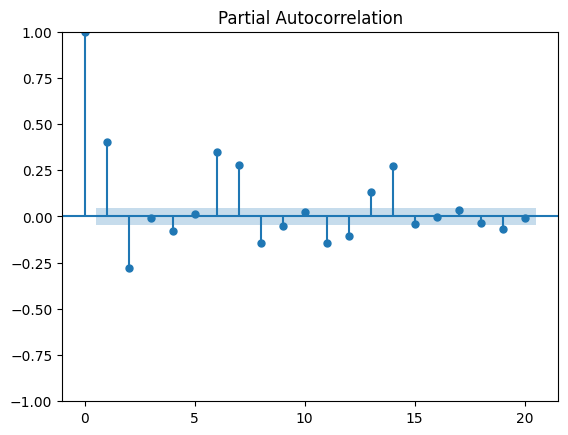

In [ ]:
# Recompute residuals after holidays
y_resid_tx = (
    (y_tx - y_trend_tx).replace([np.inf, -np.inf], np.nan).dropna(how="all", axis=0)
)

# Global standardized residual mean for PACF
global_tx_cycle = zscore_cols(y_resid_tx).mean(axis=1).dropna()
_ = plot_lags(global_tx_cycle, lags=12, nrows=2)
_ = plot_pacf(global_tx_cycle, lags=20)

### Add transaction lags to features and train the full model

In [ ]:
# Choose lags (adjust after PACF review)
L_TX = 14

# Build lags on the wide matrix (returns MultiIndex columns → flatten)
tx_lags = make_lags(y_tx, lags=L_TX, name="tx")
tx_lags.columns = tx_lags.columns.to_flat_index()
tx_lags.columns = tx_lags.columns.astype(str)

# Join to design
X_tx_full = X_tx.join(tx_lags, how="left")

# Final Ridge with larger alpha search (stabilizes many lags)
ridge_full_tx, study_full_tx = fit_ridge_with_optuna(
    X_tx_full.loc[idx_train_tx],
    y_tx.loc[idx_train_tx],
    X_tx_full.loc[idx_valid_tx],
    y_tx.loc[idx_valid_tx],
    alpha_lo=1e2,
    alpha_hi=1e5,
    patience=12,
    seed=SEED,
)

# In-sample predictions to inspect fit; valid metrics
y_pred_tx = pd.DataFrame(
    ridge_full_tx.predict(X_tx_full), index=y_tx.index, columns=y_tx.columns
)

print("Best params:", study_full_tx.best_params)
print("Best RMSLE (valid):", study_full_tx.best_value)
print("Best RMSE  (valid):", study_full_tx.best_trial.user_attrs["rmse"])

TX_BASE_COLS = X_tx_full.columns.astype(str).tolist()
TX_BASE_DTYPES = {c: "float32" for c in TX_BASE_COLS}

[I 2025-08-29 19:42:52,291] A new study created in memory with name: no-name-9ad743bd-e35a-4a76-8fec-71e1eb57e315
[I 2025-08-29 19:42:52,566] Trial 0 finished with value: 0.7647354437842744 and parameters: {'alpha': 1329.291894316217}. Best is trial 0 with value: 0.7647354437842744.
[I 2025-08-29 19:42:52,871] Trial 1 finished with value: 0.7724005073934068 and parameters: {'alpha': 71144.76009343415}. Best is trial 0 with value: 0.7647354437842744.
[I 2025-08-29 19:42:53,166] Trial 2 finished with value: 0.766998452740748 and parameters: {'alpha': 15702.970884055372}. Best is trial 0 with value: 0.7647354437842744.
[I 2025-08-29 19:42:53,467] Trial 3 finished with value: 0.7658897055092713 and parameters: {'alpha': 6251.373574521744}. Best is trial 0 with value: 0.7647354437842744.
[I 2025-08-29 19:42:53,772] Trial 4 finished with value: 0.7645158204137593 and parameters: {'alpha': 293.8027938703535}. Best is trial 4 with value: 0.7645158204137593.
[I 2025-08-29 19:42:54,078] Trial 5 

[Early stop] No improvement in 12 consecutive trials. Best RMSLE so far: 0.764447
Best params: {'alpha': 499.43235212456784}
Best RMSLE (valid): 0.7644466721141043
Best RMSE  (valid): 165.29711387280557


### Forecast 16 days of Transactions

In [ ]:
tx_hist = transactions.copy()  # your rolling history, wide with store columns

for date in X_tx_forecast.index:
    # Base deterministics for this day
    X_test_tx = X_tx_forecast.loc[[date]].join(national_events, how="left").fillna(0.0)

    # ⬅️ recompute *flattened* lag row (matches training names 1:1)
    tx_lags_row = lags_row_for_date(tx_hist, date=date, lags=L_TX, name="tx")

    # Concatenate along columns (avoids MultiIndex merge issues)
    X_test_tx = pd.concat([X_test_tx, tx_lags_row], axis=1)

    # Stringify and reindex to the training column space
    X_test_tx.columns = X_test_tx.columns.astype(str)
    X_test_tx = X_test_tx.reindex(columns=TX_BASE_COLS, fill_value=0).astype("float32")

    # (optional) probe — catches any drift immediately
    assert list(X_test_tx.columns) == TX_BASE_COLS, "TX columns/order mismatch."

    # Predict one day of transactions (wide per-store row)
    tx_pred_next = pd.DataFrame(
        ridge_full_tx.predict(X_test_tx), index=X_test_tx.index, columns=tx_hist.columns
    )

    # Roll history forward for the next day's lags
    tx_hist = pd.concat([tx_hist, tx_pred_next])

In [ ]:
# sanity: all these should be daily PeriodIndex
assert isinstance(y_tx.index, pd.PeriodIndex) and y_tx.index.freqstr == "D"
assert (
    isinstance(transactions.index, pd.PeriodIndex) and transactions.index.freqstr == "D"
)
assert (
    isinstance(X_tx_forecast.index, pd.PeriodIndex)
    and X_tx_forecast.index.freqstr == "D"
)

In [62]:
tx_hist.tail()

store_nbr,1,10,11,12,13,14,15,16,17,18,...,5,50,51,52,53,54,6,7,8,9
2017-08-27,773.798429,879.499028,2452.382046,1146.510674,787.617762,947.861903,1120.217379,851.796656,1646.211393,1300.836875,...,1172.159850,2761.971817,1674.990651,0.0,1335.249989,1043.697564,1965.674140,1643.170901,2635.641830,2092.605835
2017-08-28,1804.062616,900.524207,2202.682952,1160.356771,851.649397,1328.440663,1444.204703,698.862484,1533.266620,1317.096919,...,1249.505556,2351.957847,1545.341822,0.0,1136.753025,801.151175,1693.019803,1902.946839,2753.624801,1963.104950
2017-08-29,1652.371934,945.010228,2350.617473,1158.216800,852.813405,1255.341343,1416.198299,720.032175,1542.759290,1372.160980,...,1200.443207,2382.586494,1492.030910,0.0,1128.311018,800.940361,1699.992473,1819.544394,2660.664831,2030.086821
2017-08-30,1800.643127,835.057801,2239.305756,1139.198708,782.491153,1176.180379,1380.961517,658.064635,1423.788206,1279.086485,...,1248.560005,2351.478950,1660.709892,0.0,1192.734984,745.264052,1749.277768,1961.475656,2830.468847,1912.435570
2017-08-31,1675.065083,901.596813,2360.422710,1176.002788,868.773375,1330.996149,1384.805872,682.042649,1477.168146,1313.566716,...,1211.410500,2438.125059,1514.428769,0.0,1205.399391,765.003512,1708.669215,1866.207243,2698.019242,2062.144058


### Predict `y_pred_test`

In [ ]:
# Bring in forecast from our seasonality training
X_forecast.index.name = "date"
X_forecast.head()

,trend,trend_squared,"s(1,7)","s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=YE-DEC)",...,"sin(8,freq=YE-DEC)","cos(8,freq=YE-DEC)","sin(9,freq=YE-DEC)","cos(9,freq=YE-DEC)","sin(10,freq=YE-DEC)","cos(10,freq=YE-DEC)","sin(11,freq=YE-DEC)","cos(11,freq=YE-DEC)","sin(12,freq=YE-DEC)","cos(12,freq=YE-DEC)"
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,1685.0,2839225.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.693281,...,-0.154309,0.988023,-0.573772,-0.819015,0.981306,0.192452,-0.840618,0.541628,0.230306,-0.973118
2017-08-17,1686.0,2842596.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.705584,...,-0.017213,0.999852,-0.693281,-0.720667,0.999769,0.021516,-0.723644,0.690173,0.025818,-0.999667
2017-08-18,1687.0,2845969.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.717677,...,0.120208,0.992749,-0.796183,-0.605056,0.988678,-0.150055,-0.580800,0.814046,-0.179767,-0.983709
2017-08-19,1688.0,2849344.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.729558,...,0.255353,0.966848,-0.880012,-0.474951,0.948362,-0.317191,-0.417194,0.908818,-0.377708,-0.925925
2017-08-20,1689.0,2852721.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.741222,...,0.385663,0.922640,-0.942761,-0.333469,0.880012,-0.474951,-0.238673,0.971100,-0.559589,-0.828770


In [65]:
# Add compact onpromotion features for Test
onp_long = pd.concat([onp_long, create_onpromo_feat(test)])

In [ ]:
y_pred_test_list = []
y_hist = y.copy()  # start from train truth
for date in X_forecast.index:
    X_test = X_forecast.loc[[date]].join(national_events, how="left").fillna(0.0)

    # y-lags for this date (RAW; matches training)
    y_lags_row = lags_row_for_date(y_hist, date, lags=9, name="y", log1p=False)

    # tx-lags for this date (LOG1P; matches training of the baseline sales model)
    tx_lags_row = lags_row_for_date(tx_hist, date, lags=9, name="tx", log1p=True)

    # Join & tidy
    X_test = X_test.join(y_lags_row, how="left")
    X_test = X_test.join(tx_lags_row, how="left")
    X_test = X_test.join(oil_feats, how="left").fillna(0.0)  # shared exogenous
    X_test.columns = X_test.columns.astype(str)

    # Predict this day
    y_pred_next = hybrid_predict_one_day(
        X_test,
        y,
        ridge_full,
        final_model,
        stores,
        local_holidays,
        regional_holidays,
        onp_long,
        BASELINE_COLS,
        RESIDUAL_COLS,
        FAMILY_CATS,
        STORE_CATS,
        TYPE_CATS,
    )
    y_pred_test_list.append(y_pred_next)

    # Roll the history forward so the next day's *y* lags use today's prediction
    y_hist = pd.concat([y_hist, y_pred_next])

y_pred_test = pd.concat(y_pred_test_list).sort_index()

In [ ]:
# Sanity checks
want = test.index.to_frame(index=False).set_index(["date", "store_nbr", "family"]).index
have = y_pred_test.stack(["store_nbr", "family"]).index

missing = want.difference(have)
extra = have.difference(want)
print("Missing:", len(missing), "Extra:", len(extra))
assert len(missing) == 0 and len(extra) == 0, "Index mismatch train→test."

s = y_pred_test.stack(["store_nbr", "family"]).astype("float64")
assert np.isfinite(s).all() and (s >= 0).all(), "Found NaN/Inf/negative in predictions."

Missing: 0 Extra: 0


In [ ]:
# --- Normalize y_pred_test to avoid the old 'sales' level trap ---
if isinstance(y_pred_test, pd.DataFrame) and isinstance(
    y_pred_test.columns, pd.MultiIndex
):
    # If a stray top-level 'sales' exists, drop it
    for lvl in range(y_pred_test.columns.nlevels):
        if "sales" in y_pred_test.columns.get_level_values(lvl):
            y_pred_test = y_pred_test.xs("sales", axis=1, level=lvl, drop_level=True)
            break

# Stack to long and NAME the values 'sales'
pred_long = y_pred_test.stack(["store_nbr", "family"]).astype("float64").rename("sales")

# sanity checks
assert pred_long.index.names == ["date", "store_nbr", "family"]
assert str(test.reset_index()["date"].dtype) == "period[D]"
assert pred_long.index.get_level_values("date").dtype == "period[D]"

In [ ]:
sub = (
    test.reset_index()
    .merge(pred_long.reset_index(), on=["date", "store_nbr", "family"], how="left")
    .assign(sales=lambda d: d["sales"].fillna(0.0).clip(lower=0))[["id", "sales"]]
)
sub.sort_values(by="id").to_csv("submission.csv", index=False)

In [ ]:
zero_share = (sub["sales"] == 0).mean()
print("Zero share:", zero_share)

Zero share: 0.08487654320987655


In [ ]:
sub["sales"].describe(percentiles=[0.5, 0.9, 0.99, 0.999])

count    28512.000000
mean       486.792577
std       1285.177405
min          0.000000
50%         32.582785
90%       1267.788525
99%       7053.406458
99.9%    11458.475356
max      13986.811235
Name: sales, dtype: float64